In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\


C:\Users\User\AppData\Local\Temp\ipykernel_594476\1180076981.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17                  7.66               5.43   
647     8000         13.58  1015.12                  8.11               5.32   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-07 18:57:26,658] A new study created in memory with name: no-name-4c6a8433-0564-48f9-991b-2ce61ab0934b
[I 2025-06-07 18:59:48,834] Trial 0 finished with value: 0.19536036550998687 and parameters: {'lr': 0.1181497912338252, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3250150377631905}. Best is trial 0 with value: 0.19536036550998687.


Cross Validation Accuracies:
[0.1947382539510727, 0.1802518218755722, 0.22527456283569336, 0.20829080045223236, 0.16824638843536377]
Mean Cross Validation Accuracy:
0.19536036550998687
Standard Deviation of Cross Validation Accuracy:
0.02012897521378017


[I 2025-06-07 19:01:41,459] Trial 1 finished with value: 0.0897499680519104 and parameters: {'lr': 0.0014228085919099026, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4184930743316797}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.1135755181312561, 0.0894472748041153, 0.07233362644910812, 0.10495416074991226, 0.06843926012516022]
Mean Cross Validation Accuracy:
0.0897499680519104
Standard Deviation of Cross Validation Accuracy:
0.01764307888407462


[I 2025-06-07 19:04:20,071] Trial 2 finished with value: 0.10827454626560211 and parameters: {'lr': 0.0017152745013124327, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.45054638521250956}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.11092055588960648, 0.10575249046087265, 0.09675624221563339, 0.1274862438440323, 0.10045719891786575]
Mean Cross Validation Accuracy:
0.10827454626560211
Standard Deviation of Cross Validation Accuracy:
0.010735303479643597


[I 2025-06-07 19:08:18,018] Trial 3 finished with value: 0.09151013642549514 and parameters: {'lr': 0.008240761470747893, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1862095711059143}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.12293975055217743, 0.0879761353135109, 0.08503083884716034, 0.09134040772914886, 0.07026354968547821]
Mean Cross Validation Accuracy:
0.09151013642549514
Standard Deviation of Cross Validation Accuracy:
0.017284312893787214


[I 2025-06-07 19:13:37,374] Trial 4 finished with value: 0.193248051404953 and parameters: {'lr': 0.013169855981418961, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.27024707277904314}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.1586112082004547, 0.11626772582530975, 0.20298105478286743, 0.15805985033512115, 0.33032041788101196]
Mean Cross Validation Accuracy:
0.193248051404953
Standard Deviation of Cross Validation Accuracy:
0.07382066910310865


[I 2025-06-07 19:18:19,743] Trial 5 finished with value: 0.3236813396215439 and parameters: {'lr': 0.0015585631899080283, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.17594556364159117}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.2621755599975586, 0.41402068734169006, 0.16448326408863068, 0.2951212525367737, 0.4826059341430664]
Mean Cross Validation Accuracy:
0.3236813396215439
Standard Deviation of Cross Validation Accuracy:
0.11257076995842115


[I 2025-06-07 19:23:10,499] Trial 6 finished with value: 0.8867334485054016 and parameters: {'lr': 0.2953007585691009, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2943588965381503}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.754772961139679, 0.8011072278022766, 1.1259729862213135, 0.9440926909446716, 0.8077213764190674]
Mean Cross Validation Accuracy:
0.8867334485054016
Standard Deviation of Cross Validation Accuracy:
0.1352878165488715


[I 2025-06-07 19:29:09,160] Trial 7 finished with value: 0.0904671534895897 and parameters: {'lr': 0.1145232505360793, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14668942028004348}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.11416032165288925, 0.08971785753965378, 0.07464879751205444, 0.10453615337610245, 0.06927263736724854]
Mean Cross Validation Accuracy:
0.0904671534895897
Standard Deviation of Cross Validation Accuracy:
0.017083865600816945


[I 2025-06-07 19:33:44,395] Trial 8 finished with value: 6.4547875881195065 and parameters: {'lr': 0.06947641720746053, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4000376434590769}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[2.743121862411499, 7.214883327484131, 7.763921737670898, 7.333166599273682, 7.218844413757324]
Mean Cross Validation Accuracy:
6.4547875881195065
Standard Deviation of Cross Validation Accuracy:
1.8667283002064001


[I 2025-06-07 19:38:29,670] Trial 9 finished with value: 0.08985618948936462 and parameters: {'lr': 0.0024117802537048827, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3174931589387387}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.11458271741867065, 0.08818335086107254, 0.07336511462926865, 0.10513967275619507, 0.06801009178161621]
Mean Cross Validation Accuracy:
0.08985618948936462
Standard Deviation of Cross Validation Accuracy:
0.017871720501285396


[I 2025-06-07 19:43:45,149] Trial 10 finished with value: 0.09097935855388642 and parameters: {'lr': 0.010691939971123374, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4977459409692392}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.11337289959192276, 0.09031166881322861, 0.07557445764541626, 0.10562025010585785, 0.07001751661300659]
Mean Cross Validation Accuracy:
0.09097935855388642
Standard Deviation of Cross Validation Accuracy:
0.016691207175053572


[I 2025-06-07 19:48:50,746] Trial 11 finished with value: 0.08988374024629593 and parameters: {'lr': 0.00111814263146484, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3709044410705344}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.11097598820924759, 0.08878776431083679, 0.07363094389438629, 0.10394806414842606, 0.07207594066858292]
Mean Cross Validation Accuracy:
0.08988374024629593
Standard Deviation of Cross Validation Accuracy:
0.015653500626137372


[I 2025-06-07 19:54:07,139] Trial 12 finished with value: 0.09035752862691879 and parameters: {'lr': 0.004175694616164508, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.39389610267182545}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.11383389681577682, 0.08950566500425339, 0.07473362237215042, 0.10494768619537354, 0.0687667727470398]
Mean Cross Validation Accuracy:
0.09035752862691879
Standard Deviation of Cross Validation Accuracy:
0.017175595587723316


[I 2025-06-07 20:00:20,580] Trial 13 finished with value: 0.0904451623558998 and parameters: {'lr': 0.003703229454508369, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.23636028535519296}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.11415422707796097, 0.08939139544963837, 0.07509172707796097, 0.10521308332681656, 0.06837537884712219]
Mean Cross Validation Accuracy:
0.0904451623558998
Standard Deviation of Cross Validation Accuracy:
0.017344307328048755


[I 2025-06-07 20:06:38,563] Trial 14 finished with value: 2.379962348937988 and parameters: {'lr': 0.9202930408827746, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3373617524980777}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[1.784247875213623, 2.3464317321777344, 2.4046289920806885, 2.483900785446167, 2.8806023597717285]
Mean Cross Validation Accuracy:
2.379962348937988
Standard Deviation of Cross Validation Accuracy:
0.3515827352929384


[I 2025-06-07 20:12:12,655] Trial 15 finished with value: 0.09132016748189926 and parameters: {'lr': 0.027449513389219127, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4453895050963329}. Best is trial 1 with value: 0.0897499680519104.


Cross Validation Accuracies:
[0.11431235820055008, 0.09172835201025009, 0.0757986456155777, 0.10613732039928436, 0.06862416118383408]
Mean Cross Validation Accuracy:
0.09132016748189926
Standard Deviation of Cross Validation Accuracy:
0.017345788031436823


[I 2025-06-07 20:18:06,622] Trial 16 finished with value: 0.08396431431174278 and parameters: {'lr': 0.0030796246239870612, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2532700307891136}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.09697974473237991, 0.08785521984100342, 0.05729502812027931, 0.10050378739833832, 0.07718779146671295]
Mean Cross Validation Accuracy:
0.08396431431174278
Standard Deviation of Cross Validation Accuracy:
0.015590168906626322


[I 2025-06-07 20:24:42,108] Trial 17 finished with value: 0.09091669023036957 and parameters: {'lr': 0.0051810497386863275, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2280997245449528}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.099894218146801, 0.09772276878356934, 0.07664189487695694, 0.10485896468162537, 0.0754656046628952]
Mean Cross Validation Accuracy:
0.09091669023036957
Standard Deviation of Cross Validation Accuracy:
0.012359705152081882


[I 2025-06-07 20:30:52,341] Trial 18 finished with value: 0.09181846380233764 and parameters: {'lr': 0.025740266035300607, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1207564308282314}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.11745862662792206, 0.0922335684299469, 0.07507892698049545, 0.10399411618709564, 0.07032708078622818]
Mean Cross Validation Accuracy:
0.09181846380233764
Standard Deviation of Cross Validation Accuracy:
0.017595047084470877


[I 2025-06-07 20:37:53,042] Trial 19 finished with value: 0.12062059044837951 and parameters: {'lr': 0.0011393825254586935, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.24372642206901018}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.13451319932937622, 0.13209667801856995, 0.09017916768789291, 0.12079443782567978, 0.12551946938037872]
Mean Cross Validation Accuracy:
0.12062059044837951
Standard Deviation of Cross Validation Accuracy:
0.015971315692970816


[I 2025-06-07 20:44:30,253] Trial 20 finished with value: 0.08749227523803711 and parameters: {'lr': 0.002758824924115071, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3550092520155815}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.1049446314573288, 0.08956355601549149, 0.06410019099712372, 0.10537061840295792, 0.07348237931728363]
Mean Cross Validation Accuracy:
0.08749227523803711
Standard Deviation of Cross Validation Accuracy:
0.016564883850067318


[I 2025-06-07 20:51:18,423] Trial 21 finished with value: 0.09291812628507615 and parameters: {'lr': 0.0031150809441076637, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3582042757247158}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.11391249299049377, 0.08594216406345367, 0.09244939684867859, 0.10357121378183365, 0.06871536374092102]
Mean Cross Validation Accuracy:
0.09291812628507615
Standard Deviation of Cross Validation Accuracy:
0.015420176247669332


[I 2025-06-07 20:57:40,422] Trial 22 finished with value: 0.08894539326429367 and parameters: {'lr': 0.005819323546070361, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.45578360093450654}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.11408556252717972, 0.0816987007856369, 0.07397767156362534, 0.10124533623456955, 0.07371969521045685]
Mean Cross Validation Accuracy:
0.08894539326429367
Standard Deviation of Cross Validation Accuracy:
0.01607287051931974


[I 2025-06-07 21:03:52,222] Trial 23 finished with value: 0.08747930973768234 and parameters: {'lr': 0.007569747784220301, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.48697426337863126}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.11449531465768814, 0.0759907066822052, 0.0726037323474884, 0.10520313680171967, 0.0691036581993103]
Mean Cross Validation Accuracy:
0.08747930973768234
Standard Deviation of Cross Validation Accuracy:
0.018627581377899396


[I 2025-06-07 21:10:41,214] Trial 24 finished with value: 0.09075882136821747 and parameters: {'lr': 0.013645719996177972, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.28278060588332016}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.11383984982967377, 0.0897754579782486, 0.07632336765527725, 0.10535235702991486, 0.06850307434797287]
Mean Cross Validation Accuracy:
0.09075882136821747
Standard Deviation of Cross Validation Accuracy:
0.017031575152240536


[I 2025-06-07 21:17:22,182] Trial 25 finished with value: 0.09341527968645096 and parameters: {'lr': 0.007784599972324522, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.49653842962380157}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.1195765882730484, 0.09229899942874908, 0.07570309191942215, 0.10486825555562973, 0.07462946325540543]
Mean Cross Validation Accuracy:
0.09341527968645096
Standard Deviation of Cross Validation Accuracy:
0.017224745567423216


[I 2025-06-07 21:23:46,046] Trial 26 finished with value: 0.09080228358507156 and parameters: {'lr': 0.017245768455037613, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.19251532504919433}. Best is trial 16 with value: 0.08396431431174278.


Cross Validation Accuracies:
[0.11380838602781296, 0.08943194150924683, 0.07657743245363235, 0.10521014034748077, 0.0689835175871849]
Mean Cross Validation Accuracy:
0.09080228358507156
Standard Deviation of Cross Validation Accuracy:
0.016835378599122326


[I 2025-06-07 21:30:00,650] Trial 27 finished with value: 0.08381235525012017 and parameters: {'lr': 0.0025910471801970643, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.26253270245524246}. Best is trial 27 with value: 0.08381235525012017.


Cross Validation Accuracies:
[0.09607527405023575, 0.09276328980922699, 0.06007664278149605, 0.10512042790651321, 0.06502614170312881]
Mean Cross Validation Accuracy:
0.08381235525012017
Standard Deviation of Cross Validation Accuracy:
0.017893229072116223


[I 2025-06-07 21:36:24,680] Trial 28 finished with value: 0.5831991314888001 and parameters: {'lr': 0.002284036421379545, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26840984887926667}. Best is trial 27 with value: 0.08381235525012017.


Cross Validation Accuracies:
[0.536789059638977, 0.5821783542633057, 0.5868772268295288, 0.6096107959747314, 0.6005402207374573]
Mean Cross Validation Accuracy:
0.5831991314888001
Standard Deviation of Cross Validation Accuracy:
0.025166463946421306


[I 2025-06-07 21:43:37,946] Trial 29 finished with value: 3.6817293643951414 and parameters: {'lr': 0.04615048268909648, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.21261068572710096}. Best is trial 27 with value: 0.08381235525012017.


Cross Validation Accuracies:
[4.52459716796875, 3.6527061462402344, 4.384040355682373, 2.5340354442596436, 3.313267707824707]
Mean Cross Validation Accuracy:
3.6817293643951414
Standard Deviation of Cross Validation Accuracy:
0.7290369725404242


[I 2025-06-07 21:49:34,492] Trial 30 finished with value: 0.09060791879892349 and parameters: {'lr': 0.006771785253793287, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3289898155046297}. Best is trial 27 with value: 0.08381235525012017.


Cross Validation Accuracies:
[0.1142449751496315, 0.08990243077278137, 0.07484769076108932, 0.10518145561218262, 0.06886304169893265]
Mean Cross Validation Accuracy:
0.09060791879892349
Standard Deviation of Cross Validation Accuracy:
0.017279008012193495


[I 2025-06-07 21:55:41,808] Trial 31 finished with value: 0.08408196866512299 and parameters: {'lr': 0.0029084904434444284, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.25270434742040715}. Best is trial 27 with value: 0.08381235525012017.


Cross Validation Accuracies:
[0.08713577687740326, 0.08952952176332474, 0.07145137339830399, 0.10320165753364563, 0.06909151375293732]
Mean Cross Validation Accuracy:
0.08408196866512299
Standard Deviation of Cross Validation Accuracy:
0.012560332456210613


[I 2025-06-07 22:01:51,217] Trial 32 finished with value: 0.08462170511484146 and parameters: {'lr': 0.002086426509544337, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24454515092984935}. Best is trial 27 with value: 0.08381235525012017.


Cross Validation Accuracies:
[0.09955257922410965, 0.07483625411987305, 0.0745367780327797, 0.10206127911806107, 0.07212163507938385]
Mean Cross Validation Accuracy:
0.08462170511484146
Standard Deviation of Cross Validation Accuracy:
0.013272394655052755


[I 2025-06-07 22:07:39,606] Trial 33 finished with value: 0.08746681958436966 and parameters: {'lr': 0.002412016544603518, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.25432288550854026}. Best is trial 27 with value: 0.08381235525012017.


Cross Validation Accuracies:
[0.13005773723125458, 0.0754430890083313, 0.06613190472126007, 0.09390969574451447, 0.07179167121648788]
Mean Cross Validation Accuracy:
0.08746681958436966
Standard Deviation of Cross Validation Accuracy:
0.023242013186275827


[I 2025-06-07 22:13:17,841] Trial 34 finished with value: 0.08439723551273345 and parameters: {'lr': 0.001672854650619617, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.21141386497446185}. Best is trial 27 with value: 0.08381235525012017.


Cross Validation Accuracies:
[0.10830361396074295, 0.085154227912426, 0.06664592772722244, 0.09271177649497986, 0.06917063146829605]
Mean Cross Validation Accuracy:
0.08439723551273345
Standard Deviation of Cross Validation Accuracy:
0.01541543355575912


[I 2025-06-07 22:19:40,226] Trial 35 finished with value: 0.08085179477930068 and parameters: {'lr': 0.001574042709649348, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.21023955903216432}. Best is trial 35 with value: 0.08085179477930068.


Cross Validation Accuracies:
[0.07578974962234497, 0.08928410708904266, 0.07170086354017258, 0.09871266782283783, 0.06877158582210541]
Mean Cross Validation Accuracy:
0.08085179477930068
Standard Deviation of Cross Validation Accuracy:
0.011361425693373067


[I 2025-06-07 22:24:47,783] Trial 36 finished with value: 0.0921446993947029 and parameters: {'lr': 0.0010527234453202698, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1612967389014344}. Best is trial 35 with value: 0.08085179477930068.


Cross Validation Accuracies:
[0.11473466455936432, 0.09045872837305069, 0.08226335048675537, 0.10441407561302185, 0.06885267794132233]
Mean Cross Validation Accuracy:
0.0921446993947029
Standard Deviation of Cross Validation Accuracy:
0.01614834936975575


[I 2025-06-07 22:30:58,056] Trial 37 finished with value: 0.15019919276237487 and parameters: {'lr': 0.0014185837184150047, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3002121511495907}. Best is trial 35 with value: 0.08085179477930068.


Cross Validation Accuracies:
[0.1568254828453064, 0.14260096848011017, 0.15800298750400543, 0.14673098921775818, 0.1468355357646942]
Mean Cross Validation Accuracy:
0.15019919276237487
Standard Deviation of Cross Validation Accuracy:
0.00609725461336809


[I 2025-06-07 22:36:14,659] Trial 38 finished with value: 0.08378128409385681 and parameters: {'lr': 0.0039816945319119555, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.19468048281054853}. Best is trial 35 with value: 0.08085179477930068.


Cross Validation Accuracies:
[0.09491463005542755, 0.07955839484930038, 0.07942075282335281, 0.09950137883424759, 0.06551126390695572]
Mean Cross Validation Accuracy:
0.08378128409385681
Standard Deviation of Cross Validation Accuracy:
0.012179601266950345


[I 2025-06-07 22:41:21,770] Trial 39 finished with value: 0.08808921873569489 and parameters: {'lr': 0.004177863497010291, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1354391867170379}. Best is trial 35 with value: 0.08085179477930068.


Cross Validation Accuracies:
[0.11504865437746048, 0.07623717188835144, 0.07816334813833237, 0.10269936919212341, 0.06829755008220673]
Mean Cross Validation Accuracy:
0.08808921873569489
Standard Deviation of Cross Validation Accuracy:
0.017725528122787514


[I 2025-06-07 22:46:37,660] Trial 40 finished with value: 0.7043945550918579 and parameters: {'lr': 0.010488950275727603, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.19649173363863537}. Best is trial 35 with value: 0.08085179477930068.


Cross Validation Accuracies:
[0.7076027989387512, 0.7607218027114868, 0.6301689743995667, 0.7158796191215515, 0.7075995802879333]
Mean Cross Validation Accuracy:
0.7043945550918579
Standard Deviation of Cross Validation Accuracy:
0.04203490778951608


[I 2025-06-07 22:52:10,695] Trial 41 finished with value: 0.08434400334954262 and parameters: {'lr': 0.003781757599590889, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2664063899894023}. Best is trial 35 with value: 0.08085179477930068.


Cross Validation Accuracies:
[0.11350324749946594, 0.09050598740577698, 0.052384767681360245, 0.09580200910568237, 0.06952400505542755]
Mean Cross Validation Accuracy:
0.08434400334954262
Standard Deviation of Cross Validation Accuracy:
0.021262843444581205


[I 2025-06-07 22:56:58,335] Trial 42 finished with value: 0.0766913577914238 and parameters: {'lr': 0.0016685410960359114, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.17376340444064092}. Best is trial 42 with value: 0.0766913577914238.


Cross Validation Accuracies:
[0.08636464178562164, 0.09044589102268219, 0.06333626806735992, 0.07120684534311295, 0.07210314273834229]
Mean Cross Validation Accuracy:
0.0766913577914238
Standard Deviation of Cross Validation Accuracy:
0.010121755019254247


[I 2025-06-07 23:01:54,042] Trial 43 finished with value: 0.07116179838776589 and parameters: {'lr': 0.0016525279492420367, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1682582935690612}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[0.08578865975141525, 0.07560966163873672, 0.04725443199276924, 0.07103418558835983, 0.07612205296754837]
Mean Cross Validation Accuracy:
0.07116179838776589
Standard Deviation of Cross Validation Accuracy:
0.01288340901561536


[I 2025-06-07 23:06:58,990] Trial 44 finished with value: 0.07599997967481613 and parameters: {'lr': 0.0016861296338775047, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10261629919650427}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[0.08507940918207169, 0.08034034073352814, 0.055142685770988464, 0.08895598351955414, 0.07048147916793823]
Mean Cross Validation Accuracy:
0.07599997967481613
Standard Deviation of Cross Validation Accuracy:
0.012121166336265919


[I 2025-06-07 23:12:37,105] Trial 45 finished with value: 0.07743783220648766 and parameters: {'lr': 0.0014696877267845465, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10263647201973092}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[0.0966576561331749, 0.08647967875003815, 0.0485849492251873, 0.07872337102890015, 0.07674350589513779]
Mean Cross Validation Accuracy:
0.07743783220648766
Standard Deviation of Cross Validation Accuracy:
0.01603608540831053


[I 2025-06-07 23:17:51,074] Trial 46 finished with value: 0.08152090311050415 and parameters: {'lr': 0.0015381999494959685, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10484803070159682}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[0.08730511367321014, 0.09895257651805878, 0.0729931890964508, 0.07165206223726273, 0.0767015740275383]
Mean Cross Validation Accuracy:
0.08152090311050415
Standard Deviation of Cross Validation Accuracy:
0.01030205988060766


[I 2025-06-07 23:22:42,394] Trial 47 finished with value: 0.07968196272850037 and parameters: {'lr': 0.001884822833486998, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.16425771952932908}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[0.09673848748207092, 0.09147283434867859, 0.06780901551246643, 0.07057632505893707, 0.07181315124034882]
Mean Cross Validation Accuracy:
0.07968196272850037
Standard Deviation of Cross Validation Accuracy:
0.011964509161957737


[I 2025-06-07 23:27:38,926] Trial 48 finished with value: 0.5709950447082519 and parameters: {'lr': 0.0010253788912311318, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.16876022723506465}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[0.5285398364067078, 0.5632284879684448, 0.5829730033874512, 0.5983678698539734, 0.5818660259246826]
Mean Cross Validation Accuracy:
0.5709950447082519
Standard Deviation of Cross Validation Accuracy:
0.023973674723358464


[I 2025-06-07 23:32:53,856] Trial 49 finished with value: 1.0044093251228332 and parameters: {'lr': 0.1971617707137751, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14842962917387856}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[1.4467031955718994, 0.9483681321144104, 0.7759160995483398, 0.9414762258529663, 0.9095829725265503]
Mean Cross Validation Accuracy:
1.0044093251228332
Standard Deviation of Cross Validation Accuracy:
0.2297504077970198


[I 2025-06-07 23:38:05,540] Trial 50 finished with value: 0.07448397427797318 and parameters: {'lr': 0.0017466110082586812, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10098771199590714}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[0.09555580466985703, 0.078883096575737, 0.05663074553012848, 0.07809577882289886, 0.0632544457912445]
Mean Cross Validation Accuracy:
0.07448397427797318
Standard Deviation of Cross Validation Accuracy:
0.013573942182600216


[I 2025-06-07 23:43:18,611] Trial 51 finished with value: 0.08458847180008888 and parameters: {'lr': 0.001928842466616955, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11788782330830273}. Best is trial 43 with value: 0.07116179838776589.


Cross Validation Accuracies:
[0.10728181153535843, 0.08322298526763916, 0.0553147979080677, 0.08507750183343887, 0.09204526245594025]
Mean Cross Validation Accuracy:
0.08458847180008888
Standard Deviation of Cross Validation Accuracy:
0.01690942389441922


[I 2025-06-07 23:48:08,987] Trial 52 finished with value: 0.06967577040195465 and parameters: {'lr': 0.0013249465771454205, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10297735831789674}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08631466329097748, 0.0856778547167778, 0.04357039928436279, 0.07054159790277481, 0.06227433681488037]
Mean Cross Validation Accuracy:
0.06967577040195465
Standard Deviation of Cross Validation Accuracy:
0.015937005594422876


[I 2025-06-07 23:53:19,335] Trial 53 finished with value: 0.07892359793186188 and parameters: {'lr': 0.0013548454011473897, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10513309506461199}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08880939334630966, 0.07461995631456375, 0.09126636385917664, 0.07254508882761002, 0.06737718731164932]
Mean Cross Validation Accuracy:
0.07892359793186188
Standard Deviation of Cross Validation Accuracy:
0.009408497536658237


[I 2025-06-07 23:58:55,119] Trial 54 finished with value: 0.08223258107900619 and parameters: {'lr': 0.0011594320427097374, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1326038375840623}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.11257878690958023, 0.07389673590660095, 0.06993721425533295, 0.08553358912467957, 0.06921657919883728]
Mean Cross Validation Accuracy:
0.08223258107900619
Standard Deviation of Cross Validation Accuracy:
0.016259566583649906


[I 2025-06-08 00:03:56,632] Trial 55 finished with value: 6.683096027374267 and parameters: {'lr': 0.881624467711784, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10120687692972163}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[4.994463920593262, 7.108860492706299, 6.5515971183776855, 6.486073970794678, 8.274484634399414]
Mean Cross Validation Accuracy:
6.683096027374267
Standard Deviation of Cross Validation Accuracy:
1.0603189260224215


[I 2025-06-08 00:09:12,532] Trial 56 finished with value: 0.09103021025657654 and parameters: {'lr': 0.004825905388877562, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14641936646901313}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.11500523239374161, 0.09092532843351364, 0.07452137023210526, 0.10539646446704865, 0.06930265575647354]
Mean Cross Validation Accuracy:
0.09103021025657654
Standard Deviation of Cross Validation Accuracy:
0.01746900323557588


[I 2025-06-08 00:14:08,043] Trial 57 finished with value: 0.11323605626821517 and parameters: {'lr': 0.0013406759760385472, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11968935511623888}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.11434410512447357, 0.09680300205945969, 0.09069876372814178, 0.13453231751918793, 0.12980209290981293]
Mean Cross Validation Accuracy:
0.11323605626821517
Standard Deviation of Cross Validation Accuracy:
0.017361836948969672


[I 2025-06-08 00:19:21,511] Trial 58 finished with value: 0.08020510673522949 and parameters: {'lr': 0.0018524045886865403, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13225034929839}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08199826627969742, 0.09315091371536255, 0.07465893775224686, 0.08150260150432587, 0.06971481442451477]
Mean Cross Validation Accuracy:
0.08020510673522949
Standard Deviation of Cross Validation Accuracy:
0.007915795037097028


[I 2025-06-08 00:24:52,892] Trial 59 finished with value: 0.45849487781524656 and parameters: {'lr': 0.003232937118226186, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1501429070913181}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.4032638967037201, 0.4671998918056488, 0.46615445613861084, 0.47600457072257996, 0.4798515737056732]
Mean Cross Validation Accuracy:
0.45849487781524656
Standard Deviation of Cross Validation Accuracy:
0.0280984180632004


[I 2025-06-08 00:30:50,944] Trial 60 finished with value: 0.07394941002130509 and parameters: {'lr': 0.002284536736505662, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.17662768876704374}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08571577817201614, 0.08967838436365128, 0.05787397921085358, 0.06863539665937424, 0.06784351170063019]
Mean Cross Validation Accuracy:
0.07394941002130509
Standard Deviation of Cross Validation Accuracy:
0.01191459828424833


[I 2025-06-08 00:36:14,968] Trial 61 finished with value: 0.07411947175860405 and parameters: {'lr': 0.002030987032900686, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18318617232101805}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.09544246643781662, 0.08385221660137177, 0.052509699016809464, 0.074474036693573, 0.0643189400434494]
Mean Cross Validation Accuracy:
0.07411947175860405
Standard Deviation of Cross Validation Accuracy:
0.01491680153658296


[I 2025-06-08 00:41:30,895] Trial 62 finished with value: 0.0798202097415924 and parameters: {'lr': 0.0021954583173257203, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18097917498300137}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.09140431880950928, 0.0981559157371521, 0.053342364728450775, 0.07597703486680984, 0.08022141456604004]
Mean Cross Validation Accuracy:
0.0798202097415924
Standard Deviation of Cross Validation Accuracy:
0.015403875695566146


[I 2025-06-08 00:46:51,205] Trial 63 finished with value: 0.08116618618369102 and parameters: {'lr': 0.002549591711757112, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12191363007420344}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.12179993838071823, 0.0803024023771286, 0.052355606108903885, 0.08638598024845123, 0.06498700380325317]
Mean Cross Validation Accuracy:
0.08116618618369102
Standard Deviation of Cross Validation Accuracy:
0.02354106903646303


[I 2025-06-08 00:52:08,784] Trial 64 finished with value: 0.08807751685380935 and parameters: {'lr': 0.0010107619914444315, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18003822568549252}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.10795830190181732, 0.0898650661110878, 0.0741635113954544, 0.10167767107486725, 0.06672303378582001]
Mean Cross Validation Accuracy:
0.08807751685380935
Standard Deviation of Cross Validation Accuracy:
0.01570362146961667


[I 2025-06-08 00:57:21,192] Trial 65 finished with value: 0.08760341554880142 and parameters: {'lr': 0.005058107950493721, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.22892480700231282}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.09560863673686981, 0.09056352078914642, 0.07567223906517029, 0.10498704016208649, 0.0711856409907341]
Mean Cross Validation Accuracy:
0.08760341554880142
Standard Deviation of Cross Validation Accuracy:
0.01254537753694565


[I 2025-06-08 01:03:08,409] Trial 66 finished with value: 0.08470454066991806 and parameters: {'lr': 0.0031247339010511766, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15400204191268502}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.11641920357942581, 0.08761212974786758, 0.07454565167427063, 0.07711135596036911, 0.06783436238765717]
Mean Cross Validation Accuracy:
0.08470454066991806
Standard Deviation of Cross Validation Accuracy:
0.017086464307424165


[I 2025-06-08 01:08:33,311] Trial 67 finished with value: 0.6445659816265106 and parameters: {'lr': 0.0892271011320874, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1368786123527549}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.48976343870162964, 0.9783239960670471, 0.488673597574234, 0.6532936096191406, 0.6127752661705017]
Mean Cross Validation Accuracy:
0.6445659816265106
Standard Deviation of Cross Validation Accuracy:
0.1793028142469516


[I 2025-06-08 01:14:11,267] Trial 68 finished with value: 0.07392739430069924 and parameters: {'lr': 0.002065061970240844, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1750520291062786}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08632329106330872, 0.08831315487623215, 0.057972829788923264, 0.06569810211658478, 0.07132959365844727]
Mean Cross Validation Accuracy:
0.07392739430069924
Standard Deviation of Cross Validation Accuracy:
0.011744158638869474


[I 2025-06-08 01:19:44,192] Trial 69 finished with value: 0.0898465558886528 and parameters: {'lr': 0.0012417018693065783, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11577804949518226}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.11063799262046814, 0.08784080296754837, 0.0750693678855896, 0.10629682242870331, 0.06938779354095459]
Mean Cross Validation Accuracy:
0.0898465558886528
Standard Deviation of Cross Validation Accuracy:
0.016394172119809973


[I 2025-06-08 01:25:29,458] Trial 70 finished with value: 0.5194239735603332 and parameters: {'lr': 0.0020362582818032483, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.20366418911495554}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.46617674827575684, 0.5167736411094666, 0.534520149230957, 0.5377897024154663, 0.5418596267700195]
Mean Cross Validation Accuracy:
0.5194239735603332
Standard Deviation of Cross Validation Accuracy:
0.027967282005266287


[I 2025-06-08 01:31:16,778] Trial 71 finished with value: 0.07535862922668457 and parameters: {'lr': 0.0016850134645594198, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.16881874565262428}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08185825496912003, 0.07174702733755112, 0.05219502002000809, 0.09621815383434296, 0.07477468997240067]
Mean Cross Validation Accuracy:
0.07535862922668457
Standard Deviation of Cross Validation Accuracy:
0.014333892328234846


[I 2025-06-08 01:37:18,379] Trial 72 finished with value: 0.08162554875016212 and parameters: {'lr': 0.0023877153642208977, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.22153538377373772}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.10777996480464935, 0.08193179965019226, 0.05068681016564369, 0.09014052152633667, 0.07758864760398865]
Mean Cross Validation Accuracy:
0.08162554875016212
Standard Deviation of Cross Validation Accuracy:
0.01860190391443375


[I 2025-06-08 01:43:09,974] Trial 73 finished with value: 0.08861674964427949 and parameters: {'lr': 0.0031199069375242154, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.18612968638807037}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.09667881578207016, 0.0950833335518837, 0.05751144886016846, 0.10813748091459274, 0.08567266911268234]
Mean Cross Validation Accuracy:
0.08861674964427949
Standard Deviation of Cross Validation Accuracy:
0.017111866725863255


[I 2025-06-08 01:48:28,988] Trial 74 finished with value: 0.08630051761865616 and parameters: {'lr': 0.005961244089406948, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.16152994577518467}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.10695616155862808, 0.08928931504487991, 0.07138635963201523, 0.0964755043387413, 0.06739524751901627]
Mean Cross Validation Accuracy:
0.08630051761865616
Standard Deviation of Cross Validation Accuracy:
0.014959680727706948


[I 2025-06-08 01:53:42,501] Trial 75 finished with value: 0.08413618505001068 and parameters: {'lr': 0.0017343483773391204, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.14304348036552797}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.09744731336832047, 0.08783341199159622, 0.07196701318025589, 0.0909898653626442, 0.07244332134723663]
Mean Cross Validation Accuracy:
0.08413618505001068
Standard Deviation of Cross Validation Accuracy:
0.010223897139145689


[I 2025-06-08 01:59:10,092] Trial 76 finished with value: 0.07133323922753335 and parameters: {'lr': 0.0012705056302913364, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13029589643597642}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.09247038513422012, 0.07011809945106506, 0.049774397164583206, 0.07603385299444199, 0.06826946139335632]
Mean Cross Validation Accuracy:
0.07133323922753335
Standard Deviation of Cross Validation Accuracy:
0.01374424735847689


[I 2025-06-08 02:05:06,472] Trial 77 finished with value: 0.10334117859601974 and parameters: {'lr': 0.001265726786935502, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12808610862495384}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.12135443091392517, 0.09732283651828766, 0.08997486531734467, 0.12014985829591751, 0.08790390193462372]
Mean Cross Validation Accuracy:
0.10334117859601974
Standard Deviation of Cross Validation Accuracy:
0.014561574468930544


[I 2025-06-08 02:11:10,536] Trial 78 finished with value: 0.07734663560986518 and parameters: {'lr': 0.002621574029327708, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15290004768696194}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.0926346555352211, 0.08734742552042007, 0.059914179146289825, 0.08541702479124069, 0.06141989305615425]
Mean Cross Validation Accuracy:
0.07734663560986518
Standard Deviation of Cross Validation Accuracy:
0.013830561813163165


[I 2025-06-08 02:17:12,813] Trial 79 finished with value: 0.08711991459131241 and parameters: {'lr': 0.0021377299706494667, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17261329010262944}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.09752728790044785, 0.08898743242025375, 0.07344717532396317, 0.10544709861278534, 0.07019057869911194]
Mean Cross Validation Accuracy:
0.08711991459131241
Standard Deviation of Cross Validation Accuracy:
0.013573746196374177


[I 2025-06-08 02:23:10,660] Trial 80 finished with value: 0.24481772780418395 and parameters: {'lr': 0.041224535152309554, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19079766040600563}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.2680906057357788, 0.15283341705799103, 0.09645551443099976, 0.5148795247077942, 0.19182957708835602]
Mean Cross Validation Accuracy:
0.24481772780418395
Standard Deviation of Cross Validation Accuracy:
0.14611995407250267


[I 2025-06-08 02:28:54,205] Trial 81 finished with value: 0.0826276682317257 and parameters: {'lr': 0.0015720841242021645, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11332569945588684}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.10638710856437683, 0.07230887562036514, 0.056679774075746536, 0.10049891471862793, 0.07726366817951202]
Mean Cross Validation Accuracy:
0.0826276682317257
Standard Deviation of Cross Validation Accuracy:
0.018398019700841393


[I 2025-06-08 02:34:50,162] Trial 82 finished with value: 0.08312989696860314 and parameters: {'lr': 0.0011880164007521336, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.13971996781303297}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.10934174060821533, 0.09421821683645248, 0.04789183661341667, 0.0923006683588028, 0.07189702242612839]
Mean Cross Validation Accuracy:
0.08312989696860314
Standard Deviation of Cross Validation Accuracy:
0.02126975787569415


[I 2025-06-08 02:39:49,120] Trial 83 finished with value: 0.07292979508638382 and parameters: {'lr': 0.0018391454005275425, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12726461870652178}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08457938581705093, 0.08434741199016571, 0.05119345337152481, 0.07584791630506516, 0.06868080794811249]
Mean Cross Validation Accuracy:
0.07292979508638382
Standard Deviation of Cross Validation Accuracy:
0.012370228892359303


[I 2025-06-08 02:45:45,451] Trial 84 finished with value: 0.07029598951339722 and parameters: {'lr': 0.0033078564979680835, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15997158110006293}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.07773113995790482, 0.07366281002759933, 0.067845918238163, 0.06432835757732391, 0.06791172176599503]
Mean Cross Validation Accuracy:
0.07029598951339722
Standard Deviation of Cross Validation Accuracy:
0.0047731992494926484


[I 2025-06-08 02:51:23,615] Trial 85 finished with value: 0.09622462689876557 and parameters: {'lr': 0.0035695928392347467, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12477516485430926}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.11460071057081223, 0.1294085532426834, 0.07498740404844284, 0.09448016434907913, 0.06764630228281021]
Mean Cross Validation Accuracy:
0.09622462689876557
Standard Deviation of Cross Validation Accuracy:
0.023279333498006653


[I 2025-06-08 02:57:37,772] Trial 86 finished with value: 0.0861531749367714 and parameters: {'lr': 0.004517858165378577, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15978128636162714}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.11532926559448242, 0.06652423739433289, 0.07660998404026031, 0.10101626813411713, 0.07128611952066422]
Mean Cross Validation Accuracy:
0.0861531749367714
Standard Deviation of Cross Validation Accuracy:
0.01881251085707468


[I 2025-06-08 03:03:39,002] Trial 87 finished with value: 0.07786618620157242 and parameters: {'lr': 0.0026495502405032094, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12810466503877055}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08990611881017685, 0.10139551758766174, 0.05444232374429703, 0.07442107051610947, 0.069165900349617]
Mean Cross Validation Accuracy:
0.07786618620157242
Standard Deviation of Cross Validation Accuracy:
0.016339097533863114


[I 2025-06-08 03:09:13,472] Trial 88 finished with value: 0.07131767719984054 and parameters: {'lr': 0.0021147802493107094, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1130234420267594}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.07786010950803757, 0.07861485332250595, 0.051914967596530914, 0.07815780490636826, 0.07004065066576004]
Mean Cross Validation Accuracy:
0.07131767719984054
Standard Deviation of Cross Validation Accuracy:
0.010207208076974386


[I 2025-06-08 03:14:38,513] Trial 89 finished with value: 0.11875434219837189 and parameters: {'lr': 0.0036776758499286527, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2028170623970053}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.12326505780220032, 0.09063000231981277, 0.1316872239112854, 0.12347874045372009, 0.12471068650484085]
Mean Cross Validation Accuracy:
0.11875434219837189
Standard Deviation of Cross Validation Accuracy:
0.014397100087419597


[I 2025-06-08 03:19:56,162] Trial 90 finished with value: 0.5051089465618134 and parameters: {'lr': 0.0022215491961772777, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1136643397241334}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.46048006415367126, 0.5182269215583801, 0.4779319763183594, 0.5377018451690674, 0.5312039256095886]
Mean Cross Validation Accuracy:
0.5051089465618134
Standard Deviation of Cross Validation Accuracy:
0.03048163740926816


[I 2025-06-08 03:25:26,096] Trial 91 finished with value: 0.07771368771791458 and parameters: {'lr': 0.0014032079959154812, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10835500925483431}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.09023239463567734, 0.08207101374864578, 0.05961262434720993, 0.08465735614299774, 0.07199504971504211]
Mean Cross Validation Accuracy:
0.07771368771791458
Standard Deviation of Cross Validation Accuracy:
0.010809904347278828


[I 2025-06-08 03:31:01,866] Trial 92 finished with value: 0.08080229759216309 and parameters: {'lr': 0.002071687814678947, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14088687519842963}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.0904635637998581, 0.08390972018241882, 0.06802348047494888, 0.06915777921676636, 0.09245694428682327]
Mean Cross Validation Accuracy:
0.08080229759216309
Standard Deviation of Cross Validation Accuracy:
0.010370341407860143


[I 2025-06-08 03:38:21,937] Trial 93 finished with value: 0.08190042078495026 and parameters: {'lr': 0.0014201452888881053, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1549963785120845}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.10106796026229858, 0.07883194088935852, 0.057472072541713715, 0.08340337127447128, 0.08872675895690918]
Mean Cross Validation Accuracy:
0.08190042078495026
Standard Deviation of Cross Validation Accuracy:
0.014299734888382303


[I 2025-06-08 03:45:47,214] Trial 94 finished with value: 0.07535640448331833 and parameters: {'lr': 0.0010045054287667783, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17809922630262967}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08896779268980026, 0.09293796867132187, 0.06389735639095306, 0.0670429915189743, 0.06393591314554214]
Mean Cross Validation Accuracy:
0.07535640448331833
Standard Deviation of Cross Validation Accuracy:
0.01284703490226074


[I 2025-06-08 03:52:32,015] Trial 95 finished with value: 0.07506263256072998 and parameters: {'lr': 0.002911985211387585, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12521913370502064}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.088930644094944, 0.07825896143913269, 0.05991368740797043, 0.07737219333648682, 0.07083767652511597]
Mean Cross Validation Accuracy:
0.07506263256072998
Standard Deviation of Cross Validation Accuracy:
0.00954162591944483


[I 2025-06-08 03:59:18,553] Trial 96 finished with value: 0.07933176010847091 and parameters: {'lr': 0.0017873093777995453, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1463807569004002}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.08045080304145813, 0.10888173431158066, 0.06714177876710892, 0.07951104640960693, 0.060673438012599945]
Mean Cross Validation Accuracy:
0.07933176010847091
Standard Deviation of Cross Validation Accuracy:
0.016560277803250256


[I 2025-06-08 04:06:05,637] Trial 97 finished with value: 0.07939711064100266 and parameters: {'lr': 0.0011934753173838473, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11368419390126944}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.10398369282484055, 0.08236618340015411, 0.045783959329128265, 0.07913879305124283, 0.08571292459964752]
Mean Cross Validation Accuracy:
0.07939711064100266
Standard Deviation of Cross Validation Accuracy:
0.01888446764716499


[I 2025-06-08 04:12:26,286] Trial 98 finished with value: 0.08903768658638 and parameters: {'lr': 0.0018712106493015824, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13314346731573562}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.12990200519561768, 0.07496475428342819, 0.07819169014692307, 0.08539993315935135, 0.07673005014657974]
Mean Cross Validation Accuracy:
0.08903768658638
Standard Deviation of Cross Validation Accuracy:
0.02073782419877082


[I 2025-06-08 04:18:30,850] Trial 99 finished with value: 0.09583975225687028 and parameters: {'lr': 0.016210153890796962, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.39412963592402617}. Best is trial 52 with value: 0.06967577040195465.


Cross Validation Accuracies:
[0.11644699424505234, 0.08050668239593506, 0.08627045899629593, 0.10727064311504364, 0.08870398253202438]
Mean Cross Validation Accuracy:
0.09583975225687028
Standard Deviation of Cross Validation Accuracy:
0.013659555648733132
Number of finished trials: 100
Best trial: {'lr': 0.0013249465771454205, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10297735831789674}
Best hyperparameters:  {'lr': 0.0013249465771454205, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10297735831789674}
Fold 1:
Epoch 1/100
19/19 [==============================] - 15s 393ms/step - loss: 0.2643 - val_loss: 0.1298
Epoch 2/100
19/19 [==============================] - 7s 367ms/step - loss: 0.1364 - val_loss: 0.1505
Epoch 3/100
19/19 [==============================] - 7s 354ms/step - loss: 0.1394 - val_loss: 0.0857
Epoch 4/100
19/19 [==============================] - 10

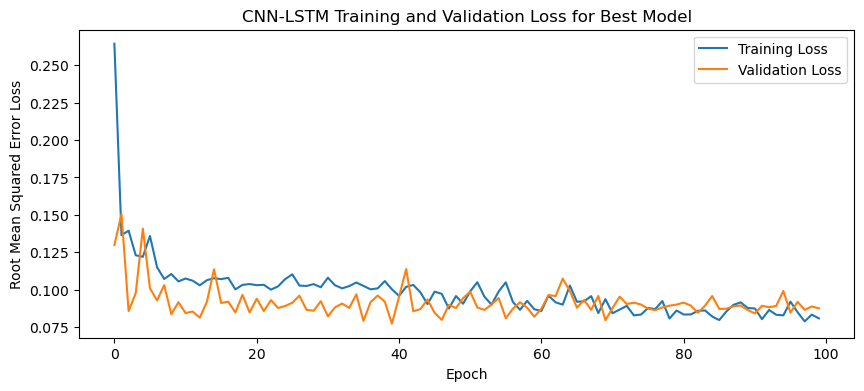

1/1 - 4s - loss: 0.0883 - 4s/epoch - 4s/step
Test Loss: 0.0882820263504982
Fold 2:
Epoch 1/100
19/19 [==============================] - 16s 364ms/step - loss: 0.2774 - val_loss: 0.1674
Epoch 2/100
19/19 [==============================] - 4s 202ms/step - loss: 0.1317 - val_loss: 0.1330
Epoch 3/100
19/19 [==============================] - 6s 334ms/step - loss: 0.1217 - val_loss: 0.1153
Epoch 4/100
19/19 [==============================] - 5s 258ms/step - loss: 0.1196 - val_loss: 0.1185
Epoch 5/100
19/19 [==============================] - 4s 232ms/step - loss: 0.1143 - val_loss: 0.1261
Epoch 6/100
19/19 [==============================] - 6s 306ms/step - loss: 0.1156 - val_loss: 0.0974
Epoch 7/100
19/19 [==============================] - 5s 245ms/step - loss: 0.1191 - val_loss: 0.0799
Epoch 8/100
19/19 [==============================] - 4s 239ms/step - loss: 0.1012 - val_loss: 0.0951
Epoch 9/100
19/19 [==============================] - 9s 461ms/step - loss: 0.1105 - val_loss: 0.0879
Epoch 1

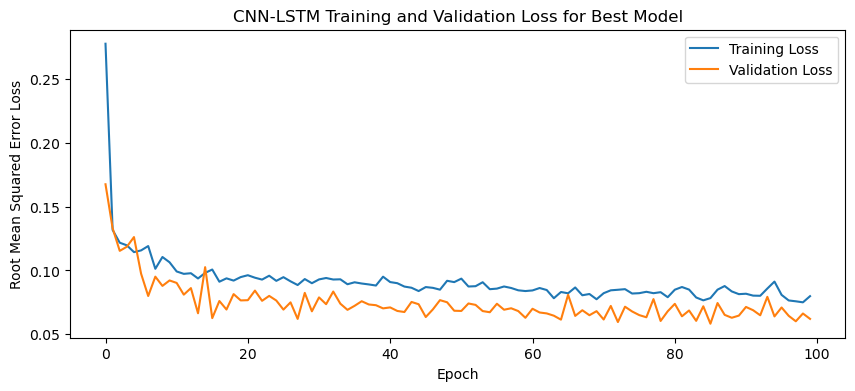

1/1 - 2s - loss: 0.0804 - 2s/epoch - 2s/step
Test Loss: 0.08043698966503143
Fold 3:
Epoch 1/100
19/19 [==============================] - 16s 380ms/step - loss: 0.2774 - val_loss: 0.1191
Epoch 2/100
19/19 [==============================] - 5s 263ms/step - loss: 0.1281 - val_loss: 0.1501
Epoch 3/100
19/19 [==============================] - 5s 240ms/step - loss: 0.1217 - val_loss: 0.1163
Epoch 4/100
19/19 [==============================] - 5s 280ms/step - loss: 0.1193 - val_loss: 0.0735
Epoch 5/100
19/19 [==============================] - 5s 257ms/step - loss: 0.1123 - val_loss: 0.0642
Epoch 6/100
19/19 [==============================] - 5s 289ms/step - loss: 0.1093 - val_loss: 0.0629
Epoch 7/100
19/19 [==============================] - 7s 385ms/step - loss: 0.1074 - val_loss: 0.0925
Epoch 8/100
19/19 [==============================] - 5s 283ms/step - loss: 0.1136 - val_loss: 0.0626
Epoch 9/100
19/19 [==============================] - 6s 322ms/step - loss: 0.1061 - val_loss: 0.0744
Epoch 

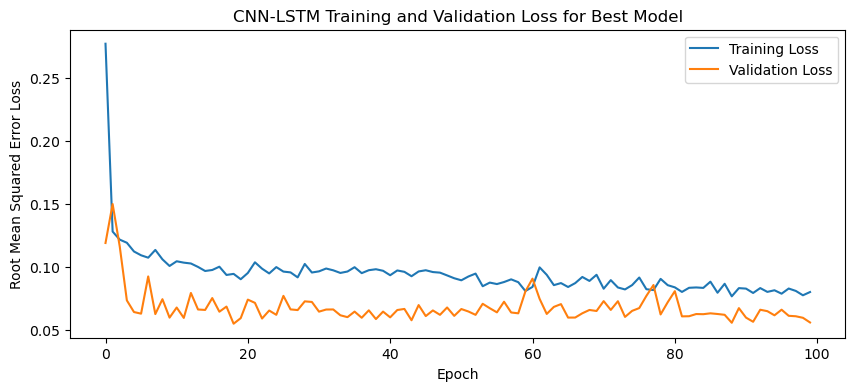

1/1 - 2s - loss: 0.0684 - 2s/epoch - 2s/step
Test Loss: 0.06840554624795914
Fold 4:
Epoch 1/100
20/20 [==============================] - 16s 369ms/step - loss: 0.2245 - val_loss: 0.1778
Epoch 2/100
20/20 [==============================] - 5s 241ms/step - loss: 0.1244 - val_loss: 0.1146
Epoch 3/100
20/20 [==============================] - 7s 349ms/step - loss: 0.1176 - val_loss: 0.1484
Epoch 4/100
20/20 [==============================] - 7s 362ms/step - loss: 0.1127 - val_loss: 0.1474
Epoch 5/100
20/20 [==============================] - 5s 241ms/step - loss: 0.1139 - val_loss: 0.1365
Epoch 6/100
20/20 [==============================] - 4s 203ms/step - loss: 0.1007 - val_loss: 0.1016
Epoch 7/100
20/20 [==============================] - 5s 242ms/step - loss: 0.1078 - val_loss: 0.1496
Epoch 8/100
20/20 [==============================] - 5s 230ms/step - loss: 0.1089 - val_loss: 0.1394
Epoch 9/100
20/20 [==============================] - 5s 249ms/step - loss: 0.1036 - val_loss: 0.1468
Epoch 

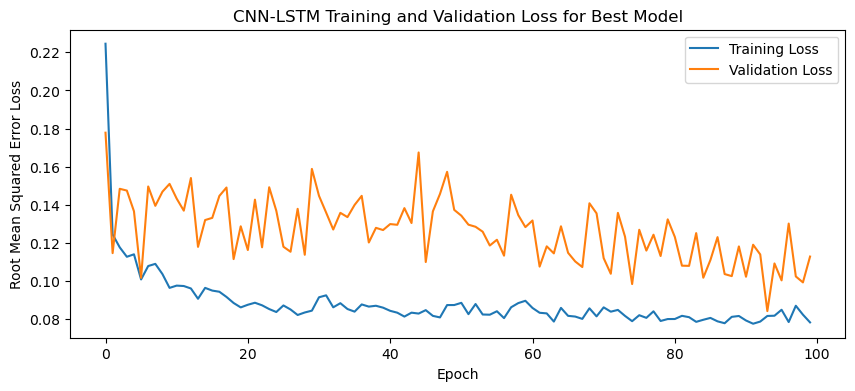

1/1 - 3s - loss: 0.0924 - 3s/epoch - 3s/step
Test Loss: 0.0923876017332077
Fold 5:
Epoch 1/100
19/19 [==============================] - 17s 415ms/step - loss: 0.2542 - val_loss: 0.1646
Epoch 2/100
19/19 [==============================] - 5s 252ms/step - loss: 0.1372 - val_loss: 0.1537
Epoch 3/100
19/19 [==============================] - 4s 226ms/step - loss: 0.1139 - val_loss: 0.1535
Epoch 4/100
19/19 [==============================] - 6s 314ms/step - loss: 0.1099 - val_loss: 0.1892
Epoch 5/100
19/19 [==============================] - 5s 279ms/step - loss: 0.1164 - val_loss: 0.1385
Epoch 6/100
19/19 [==============================] - 4s 222ms/step - loss: 0.1066 - val_loss: 0.1200
Epoch 7/100
19/19 [==============================] - 5s 252ms/step - loss: 0.1127 - val_loss: 0.1288
Epoch 8/100
19/19 [==============================] - 4s 193ms/step - loss: 0.1028 - val_loss: 0.1356
Epoch 9/100
19/19 [==============================] - 4s 201ms/step - loss: 0.0995 - val_loss: 0.1537
Epoch 1

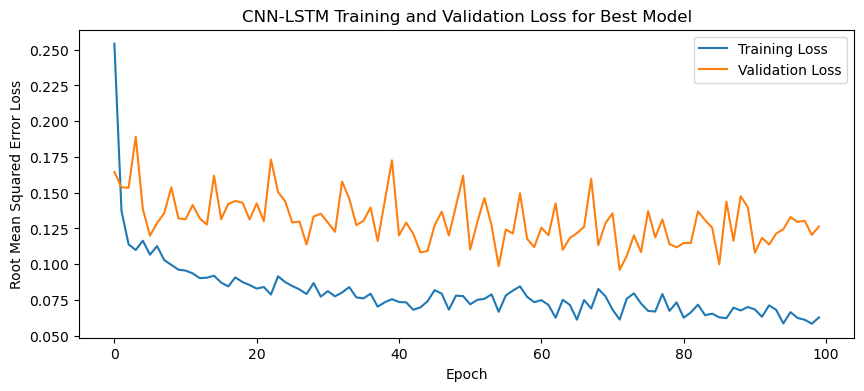

1/1 - 5s - loss: 0.0773 - 5s/epoch - 5s/step
Test Loss: 0.07725606113672256


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

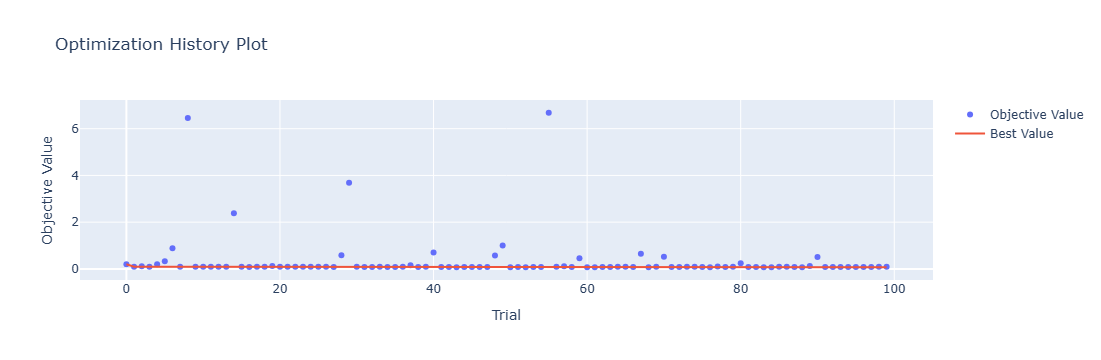

In [4]:
optuna.visualization.plot_optimization_history(study)

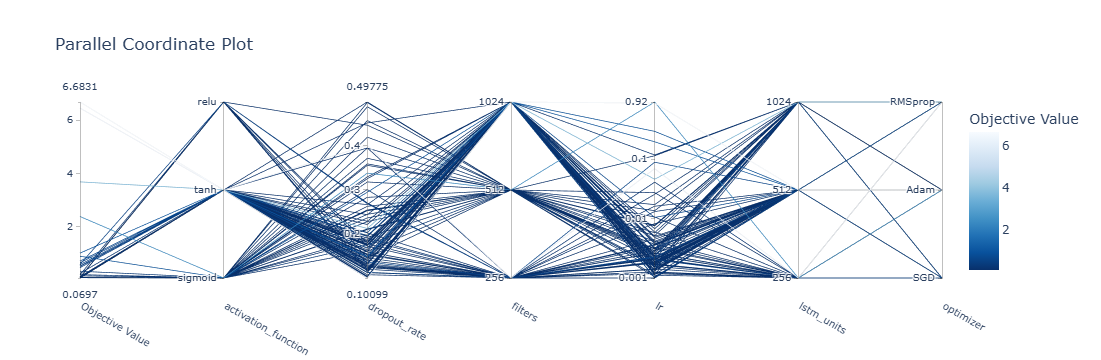

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

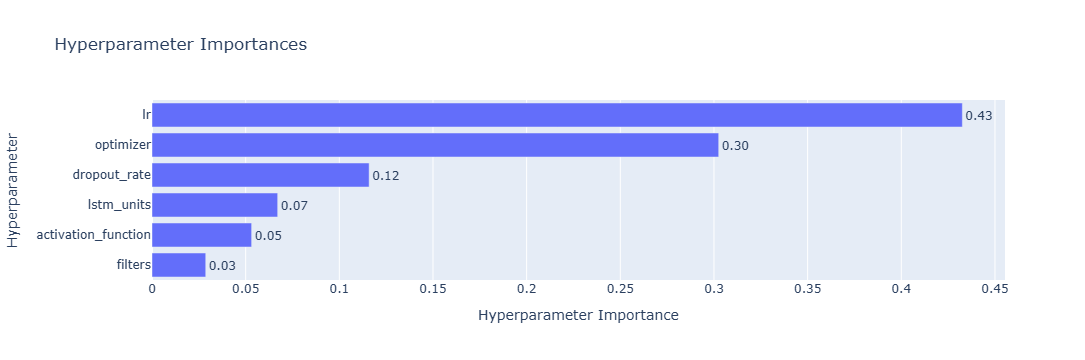

In [6]:
optuna.visualization.plot_param_importances(study)

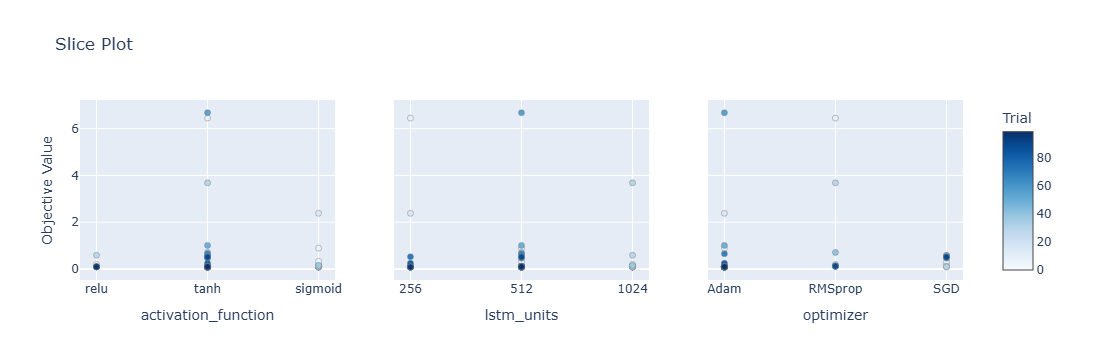

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

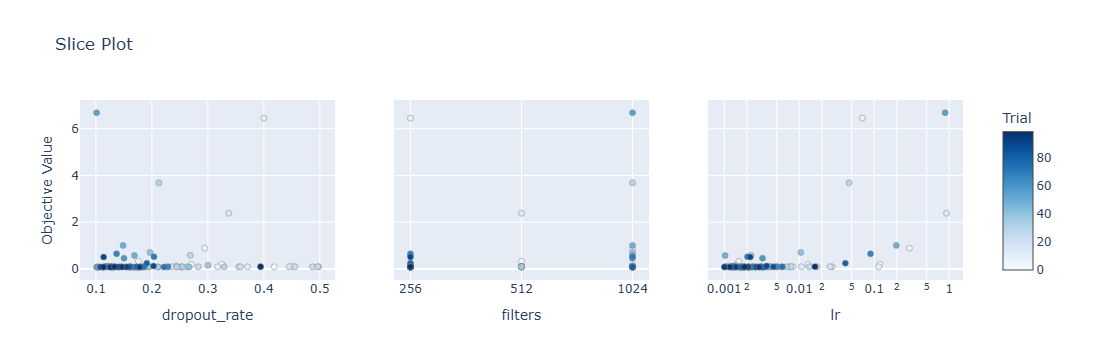

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 33s 585ms/step - loss: 0.2610 - accuracy: 0.1579 - mae: 0.2242 - rmse: 0.2610 - mape: 41.2729 - pearson: 0.2005 - val_loss: 0.1752 - val_accuracy: 0.3333 - val_mae: 0.1588 - val_rmse: 0.1752 - val_mape: 29.2241 - val_pearson: 0.4823
Epoch 2/100
19/19 [==============================] - 3s 149ms/step - loss: 0.1435 - accuracy: 0.3684 - mae: 0.1195 - rmse: 0.1435 - mape: 21.6183 - pearson: 0.3631 - val_loss: 0.0975 - val_accuracy: 0.0000e+00 - val_mae: 0.0803 - val_rmse: 0.0975 - val_mape: 14.4683 - val_pearson: 0.4729
Epoch 3/100
19/19 [==============================] - 4s 194ms/step - loss: 0.1365 - ac

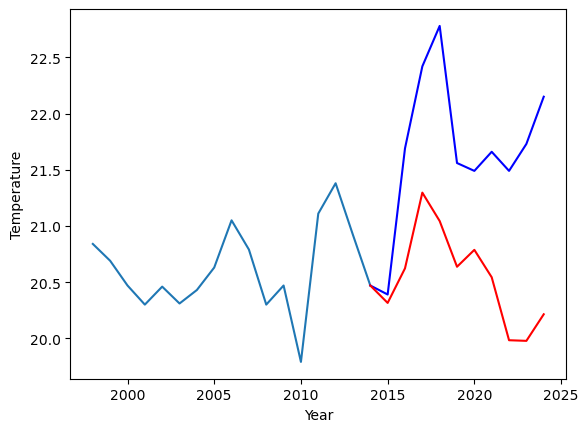

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.37		15.96		-0.41
17.64		16.36		-1.28
17.80		17.06		-0.74
18.04		16.77		-1.27
18.00		16.34		-1.66
18.95		16.47		-2.48
18.12		16.25		-1.87
17.61		15.69		-1.92
17.89		15.62		-2.27
17.72		15.86		-1.86


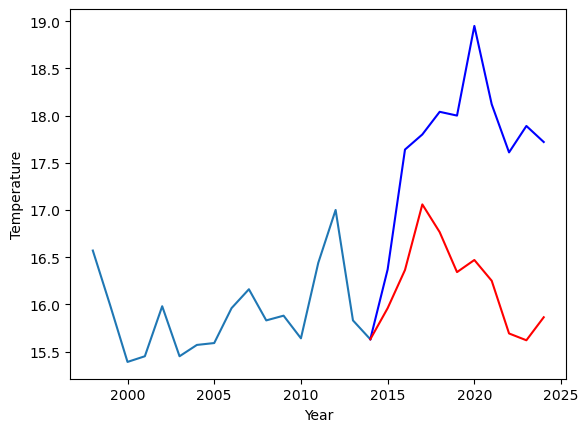

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.39  20.315114
1                1   16.37  15.959550


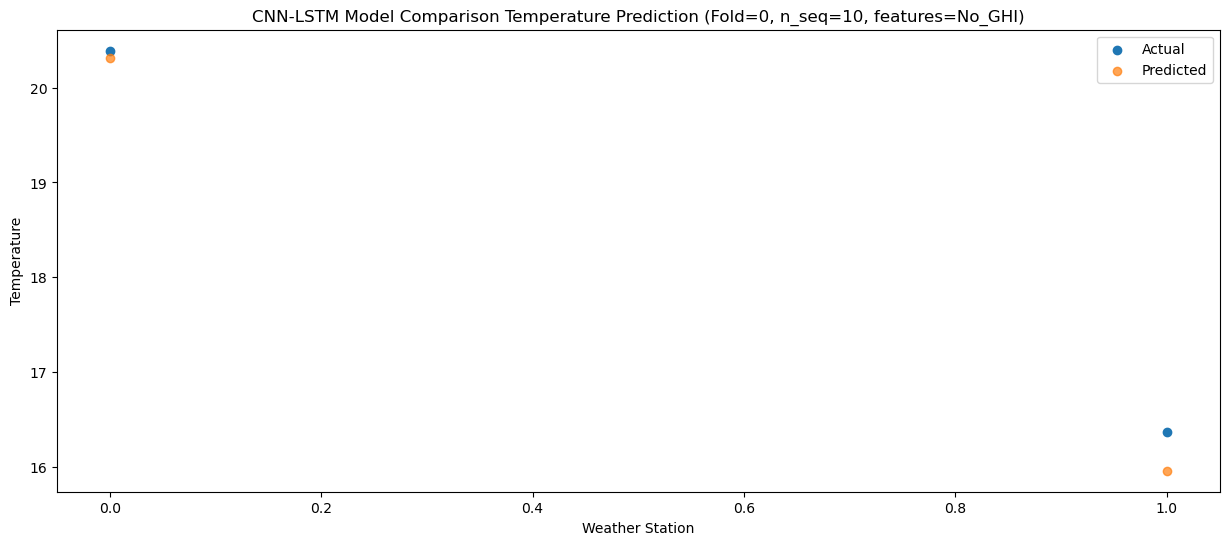

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.69  20.622644
1                1   17.64  16.364313


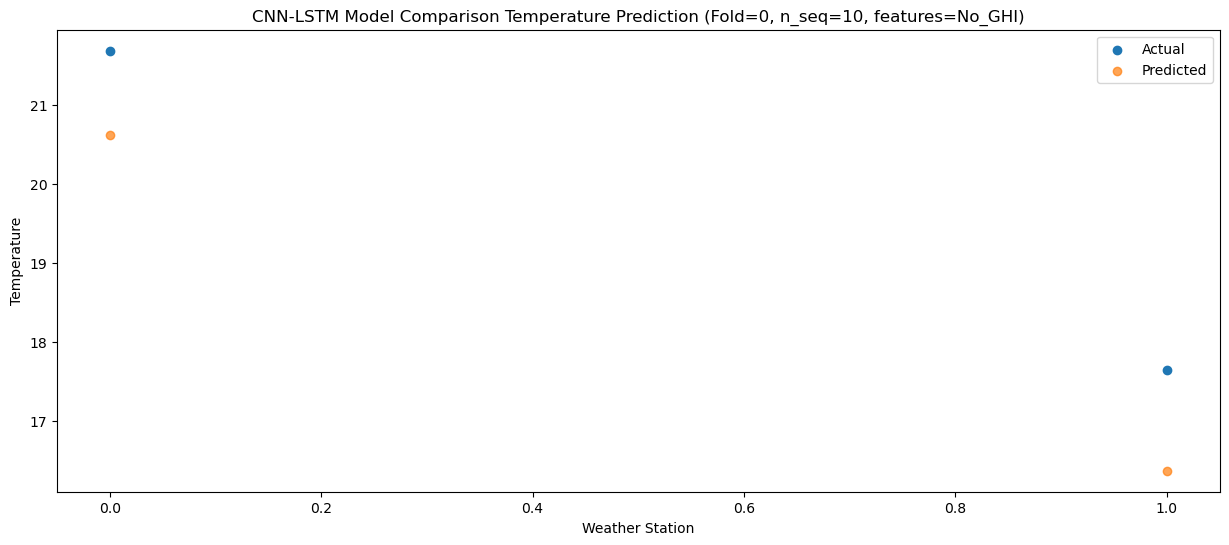

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.42  21.296481
1                1   17.80  17.058923


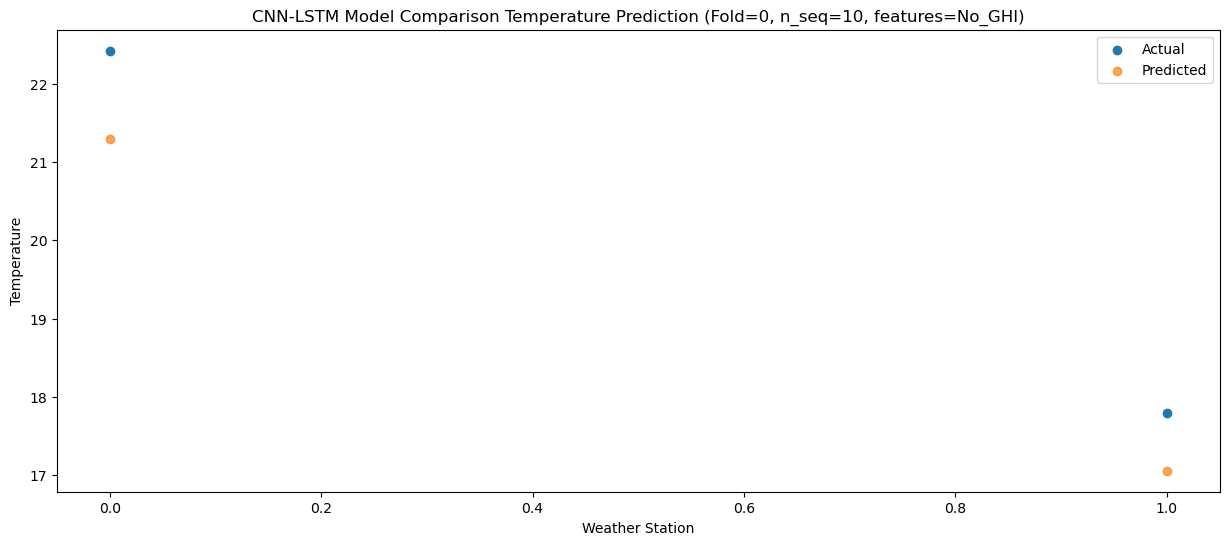

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.78  21.043761
1                1   18.04  16.765290


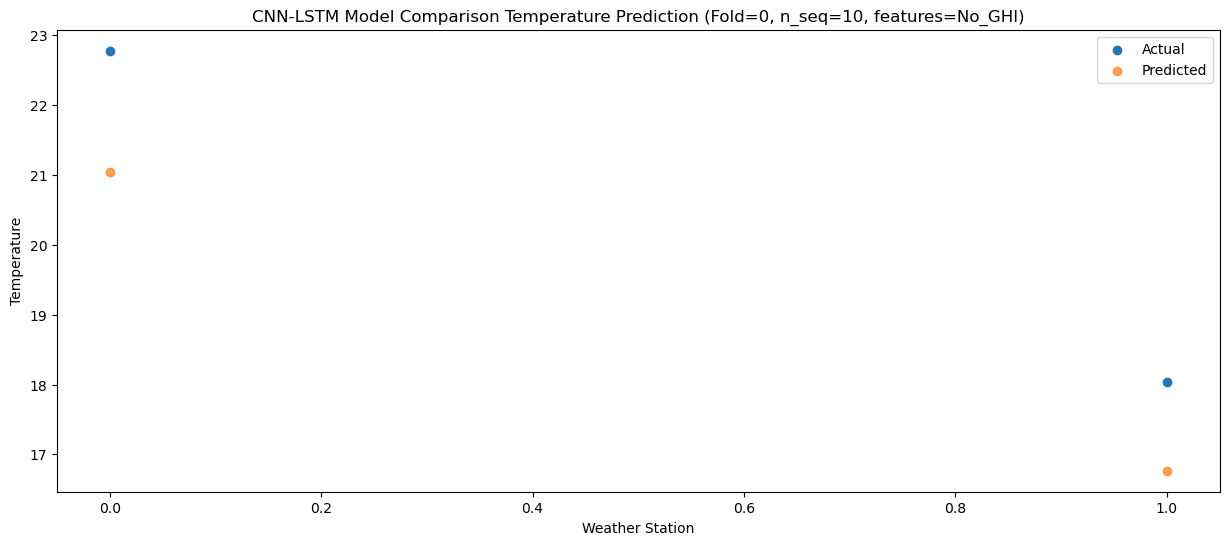

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.56  20.636936
1                1   18.00  16.341634


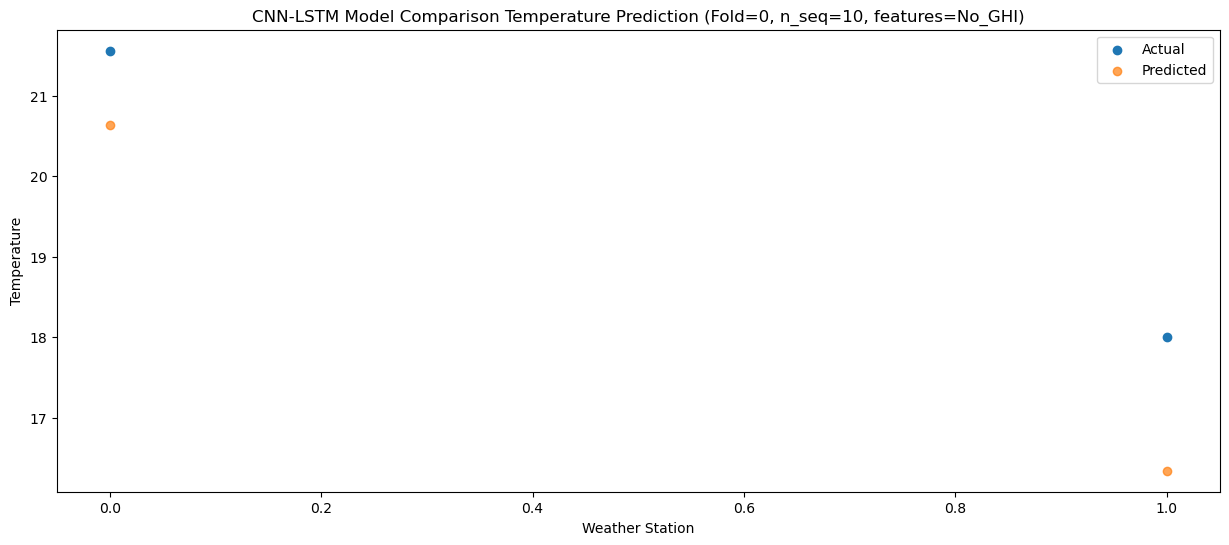

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.49  20.787303
1                1   18.95  16.469971


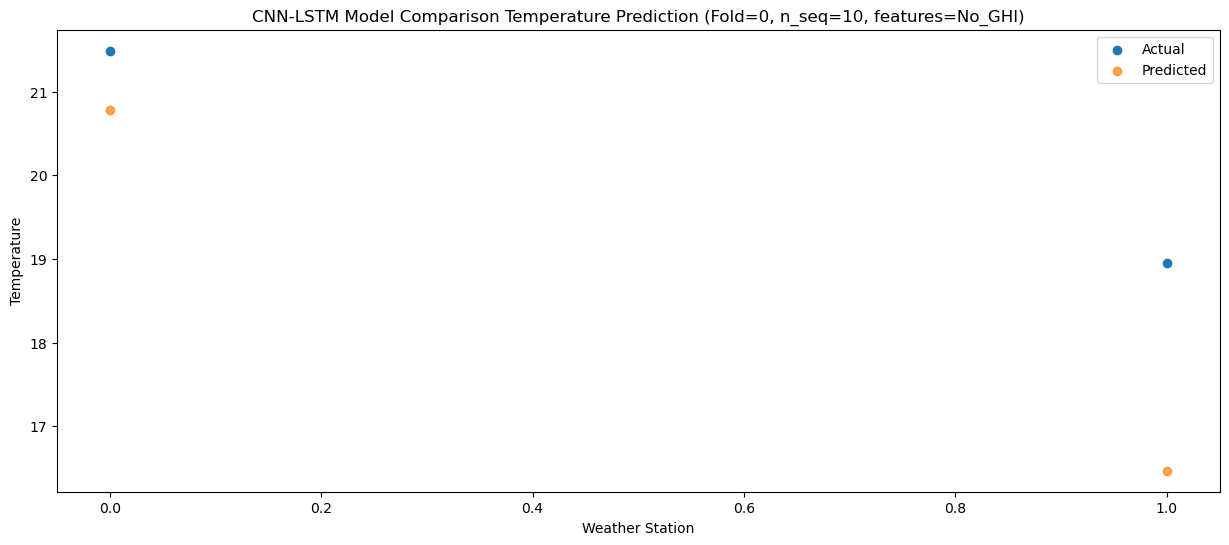

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   21.66  20.543343
1                1   18.12  16.249994


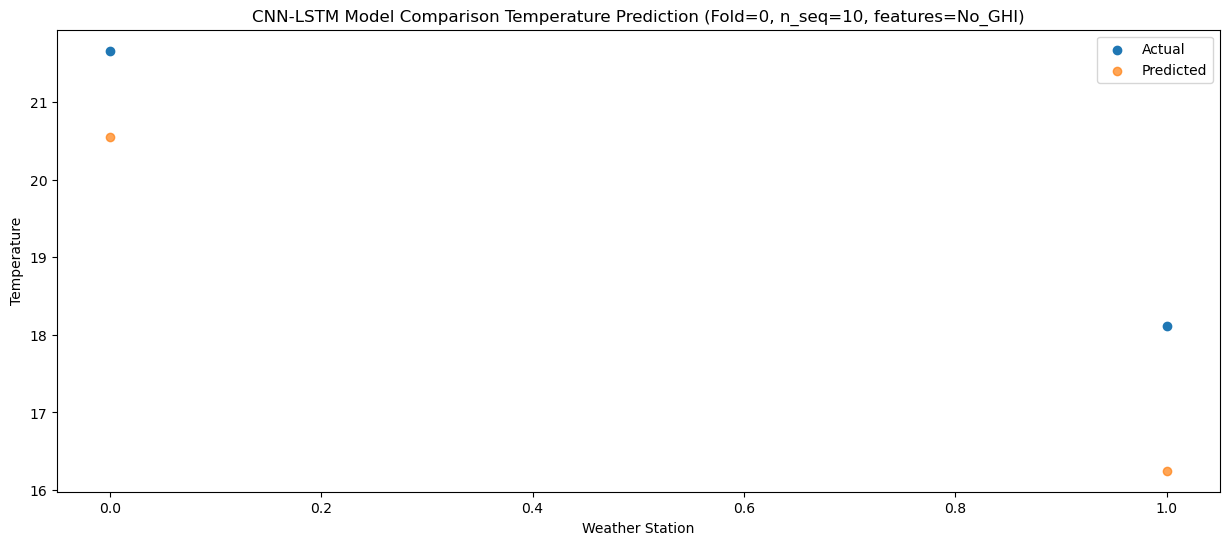

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.49  19.983059
1                1   17.61  15.691430


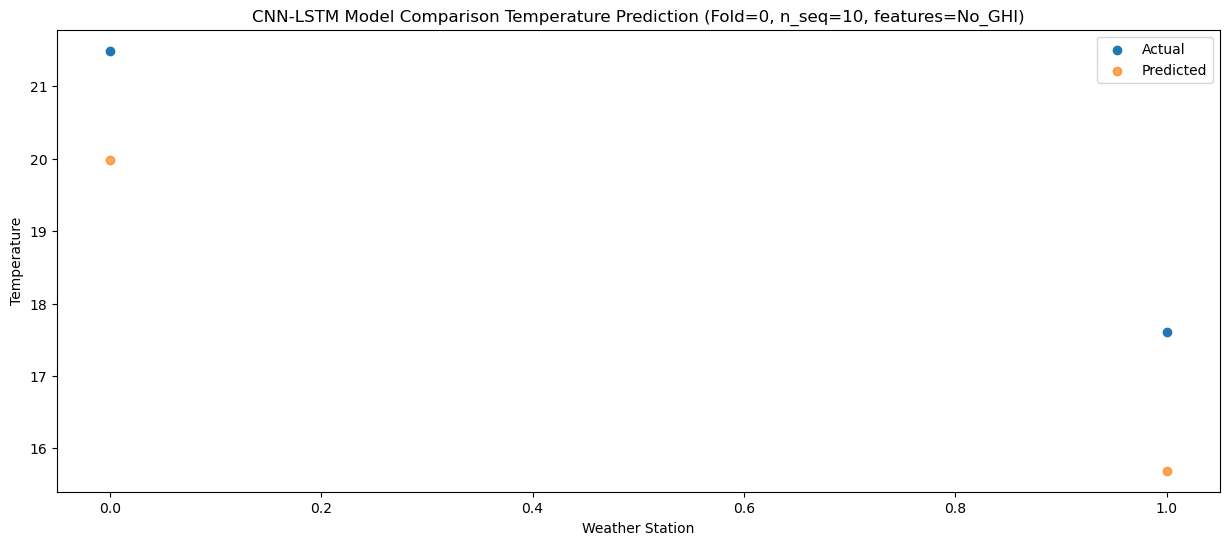

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   21.73  19.977488
1                1   17.89  15.619428


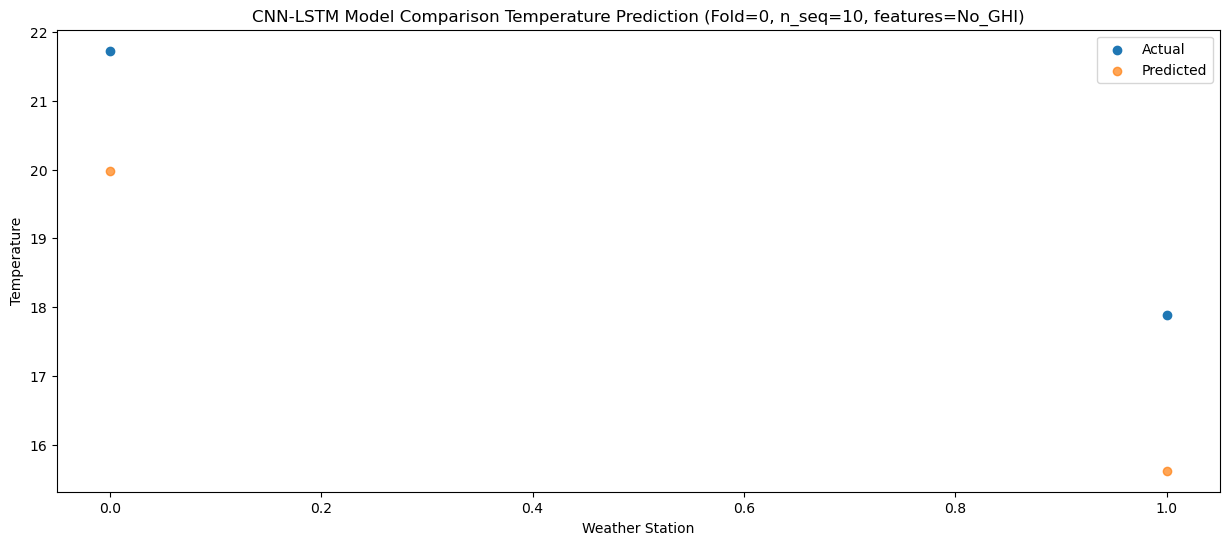

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   22.15  20.214027
1                1   17.72  15.863320


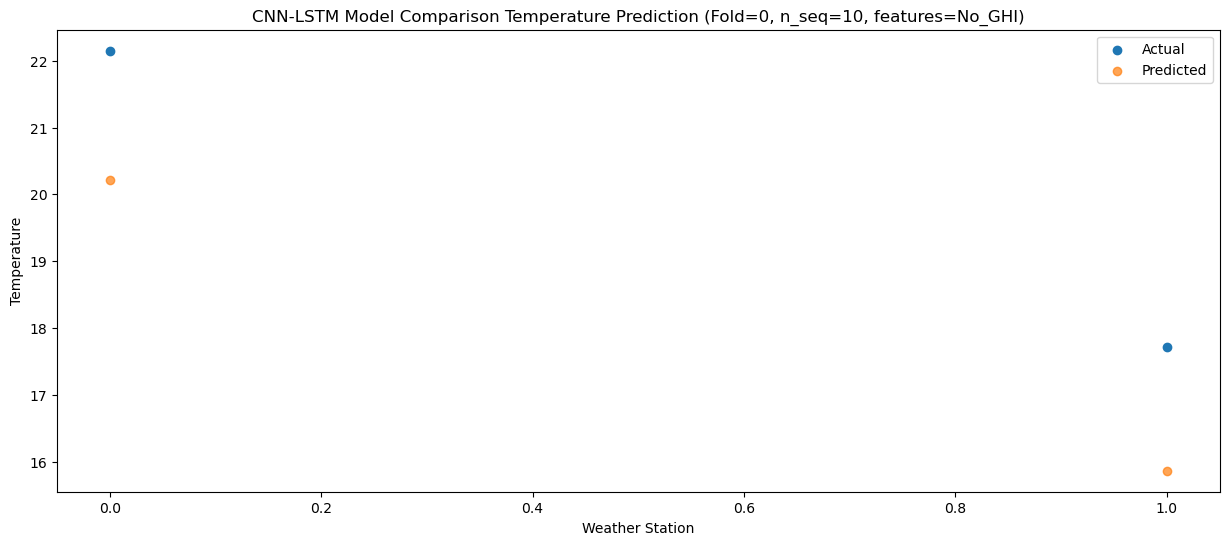

f, t:
[[20.39 16.37]
 [21.69 17.64]
 [22.42 17.8 ]
 [22.78 18.04]
 [21.56 18.  ]
 [21.49 18.95]
 [21.66 18.12]
 [21.49 17.61]
 [21.73 17.89]
 [22.15 17.72]]
[[20.31511369 15.95954955]
 [20.62264445 16.36431292]
 [21.2964808  17.05892316]
 [21.04376062 16.76528958]
 [20.63693606 16.34163386]
 [20.78730337 16.46997135]
 [20.54334266 16.24999423]
 [19.98305882 15.69142974]
 [19.97748833 15.61942799]
 [20.21402662 15.86331953]]
Year at t+1:
t+1 SKRMSE: 0.295023
t+1 KRMSE: 0.295023
t+1 MAE: 0.242668
t+1 SKMAPE: 0.014373
t+1 R2_SCORE: 0.978456
t+1 KMAPE: 0.014373
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 1.176143
t+2 KRMSE: 1.176143
t+2 MAE: 1.171521
t+2 SKMAPE: 0.060764
t+2 R2_SCORE: 0.662658
t+2 KMAPE: 0.060764
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.951706
t+3 KRMSE: 0.951706
t+3 MAE: 0.932298
t+3 SKMAPE: 0.045873
t+3 R2_SCORE: 0.830261
t+3 KMAPE: 0.045873
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.523058
t+4 KRMSE: 1.523058
t+4 MAE: 1.505475
t+4 SKMAPE: 0.073439
t+4 R

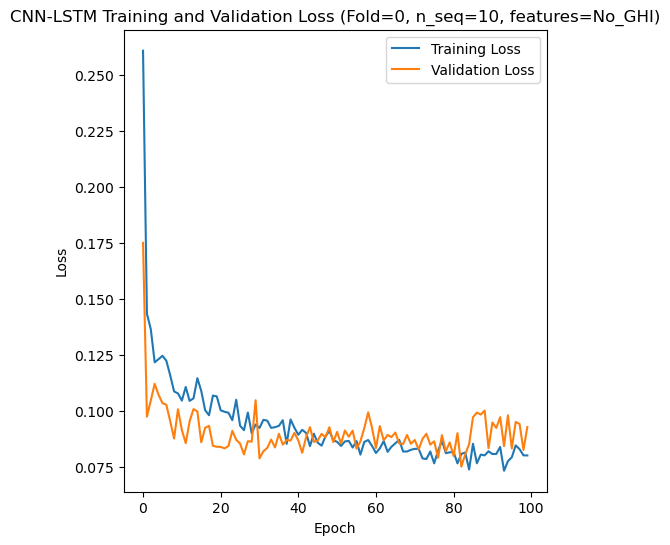

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 27s 494ms/step - loss: 0.2673 - accuracy: 0.1579 - mae: 0.2311 - rmse: 0.2673 - mape: 36.6137 - pearson: 0.1275 - val_loss: 0.1001 - val_accuracy: 0.0000e+00 - val_mae: 0.0820 - val_rmse: 0.1001 - val_mape: 13.5253 - val_pearson: 0.5185
Epoch 2/100
19/19 [==============================] - 3s 152ms/step - loss: 0.1216 - accuracy: 0.1579 - mae: 0.1008 - rmse: 0.1216 - mape: 16.6258 - pearson: 0.2957 - val_loss: 0.0850 - val_accuracy: 1.0000 - val_mae: 0.0664 - val_rmse: 0.0850 - val_mape: 11.2152 - val_pearson: 0.6538
Epoch 3/100
19/19 [==============================] - 3s 141ms/step - loss: 0.1225 - acc

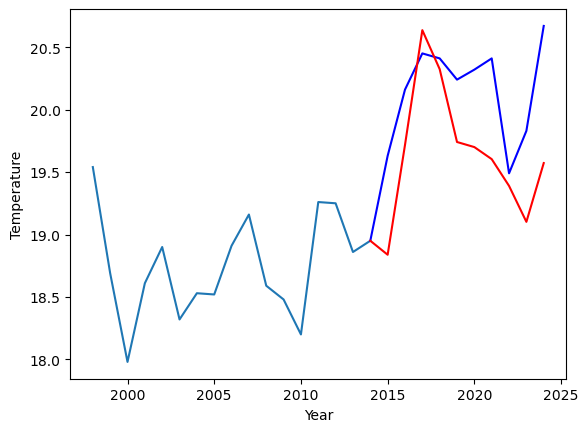

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.88		19.46		-0.42
19.40		20.09		0.69
20.43		20.68		0.25
20.81		20.03		-0.78
19.96		19.78		-0.18
20.09		19.06		-1.03
20.61		19.73		-0.88
20.22		19.63		-0.59
20.22		18.89		-1.33
21.53		19.26		-2.27


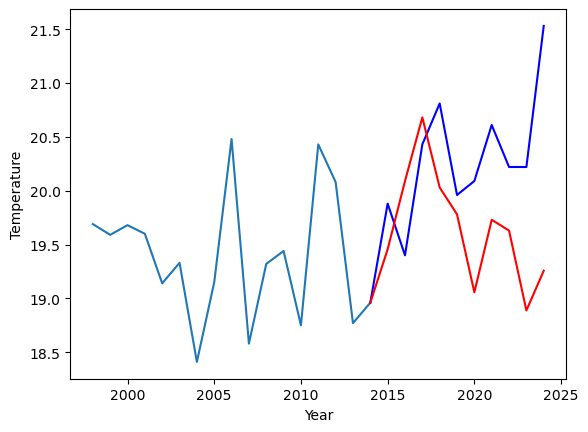

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.63  18.838108
1                1   19.88  19.456266


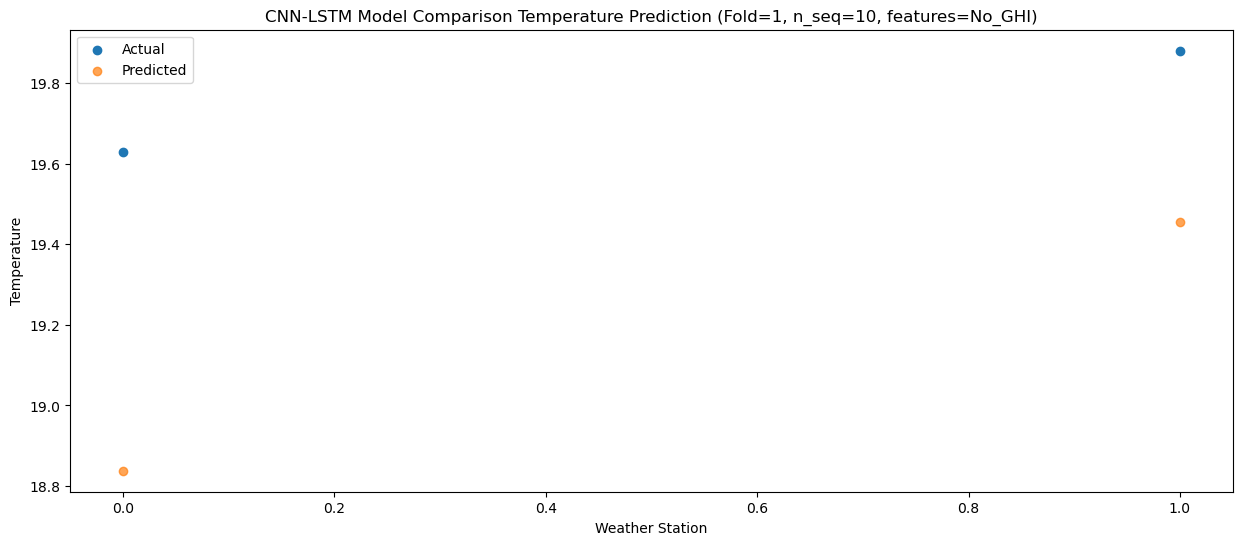

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.16  19.716830
1                1   19.40  20.089574


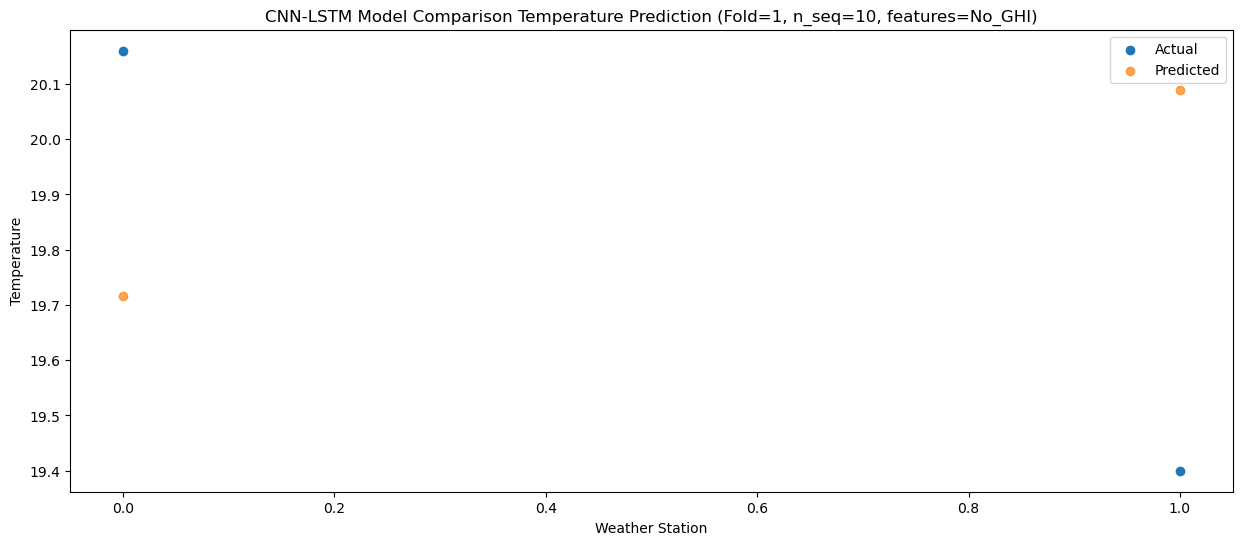

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.45  20.636095
1                1   20.43  20.680871


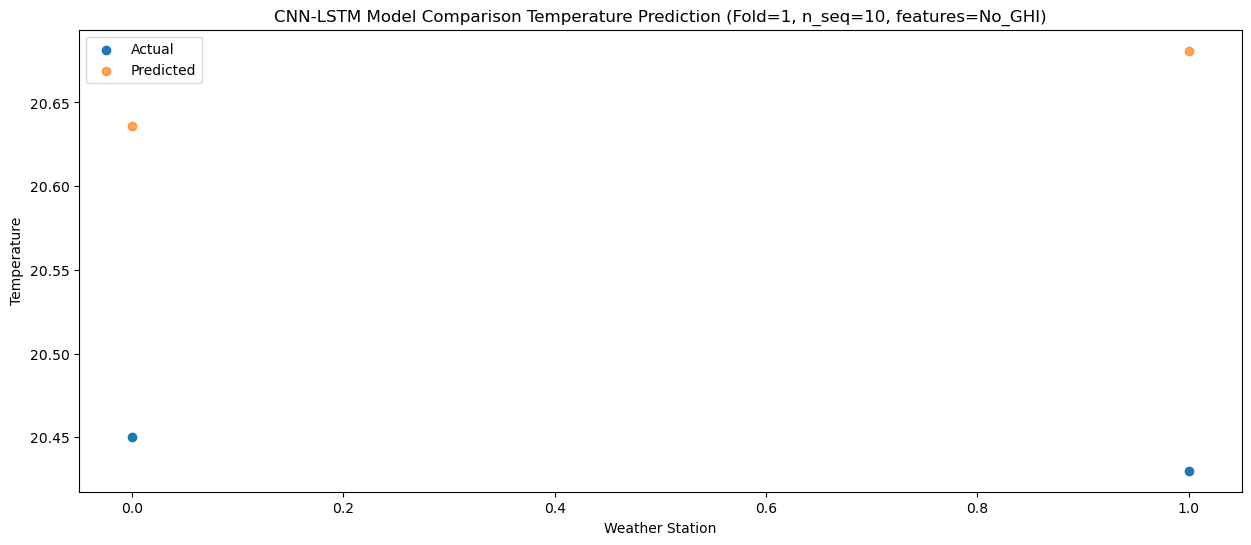

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   20.41  20.323993
1                1   20.81  20.029895


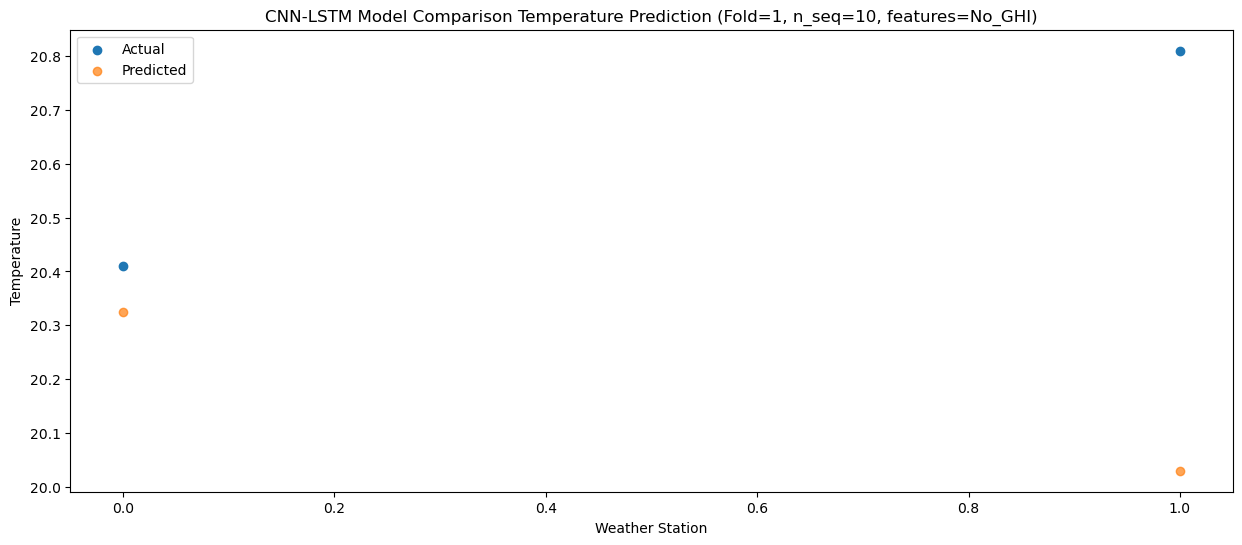

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   20.24  19.740689
1                1   19.96  19.780363


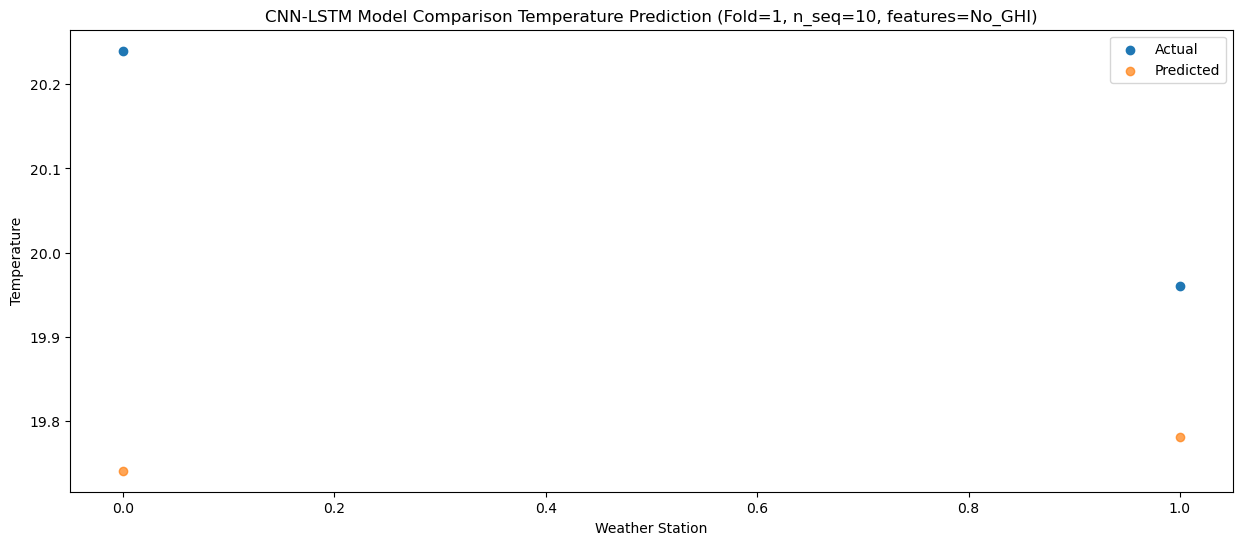

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   20.32  19.699941
1                1   20.09  19.056631


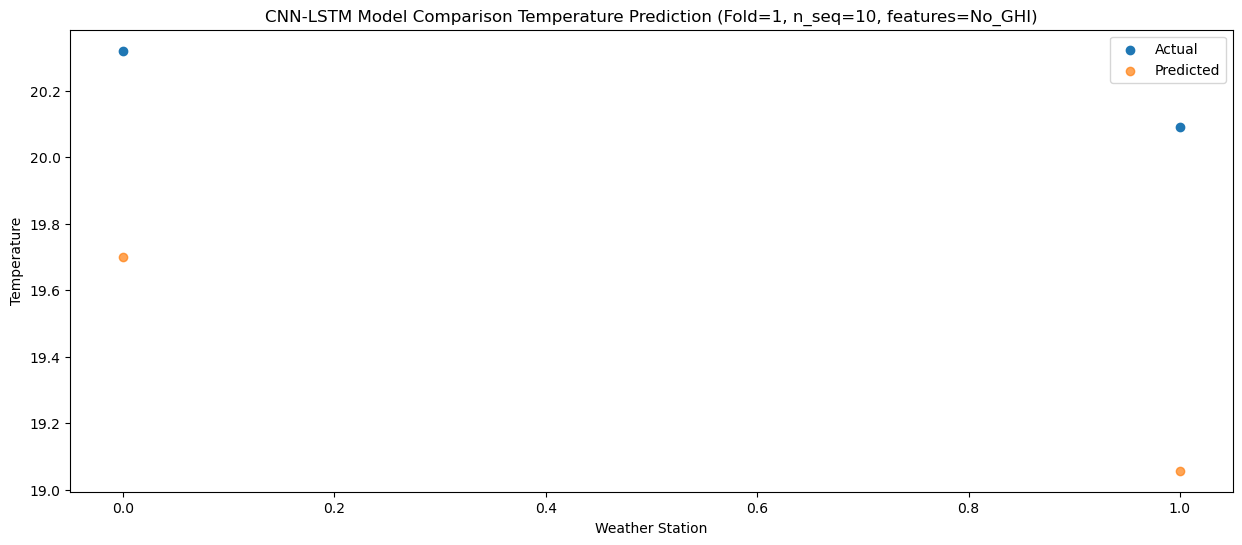

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   20.41  19.603522
1                1   20.61  19.729931


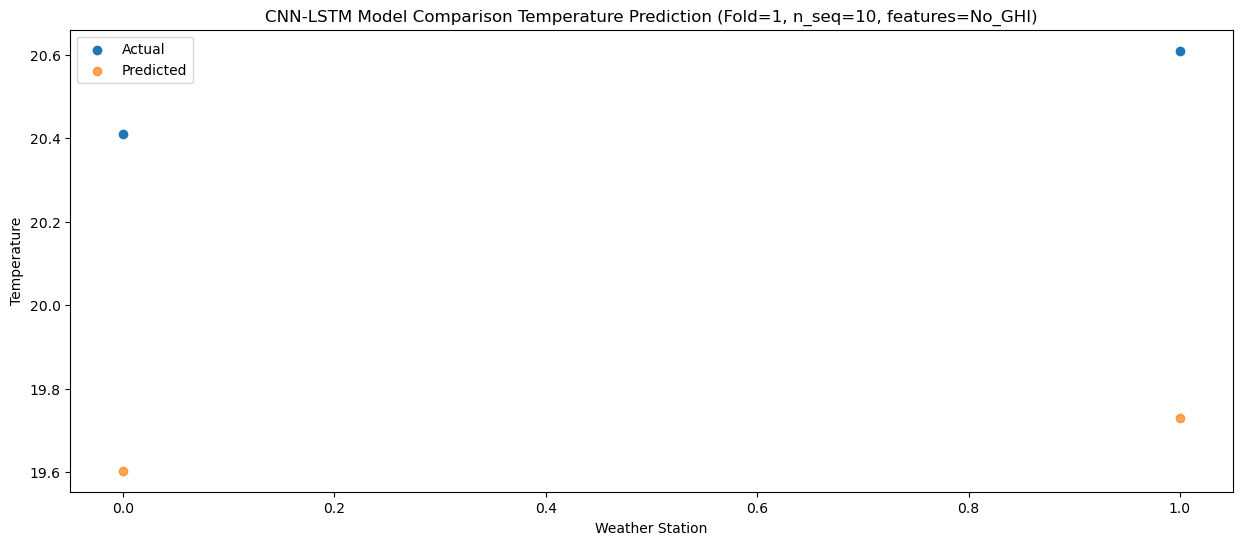

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   19.49  19.389315
1                1   20.22  19.629683


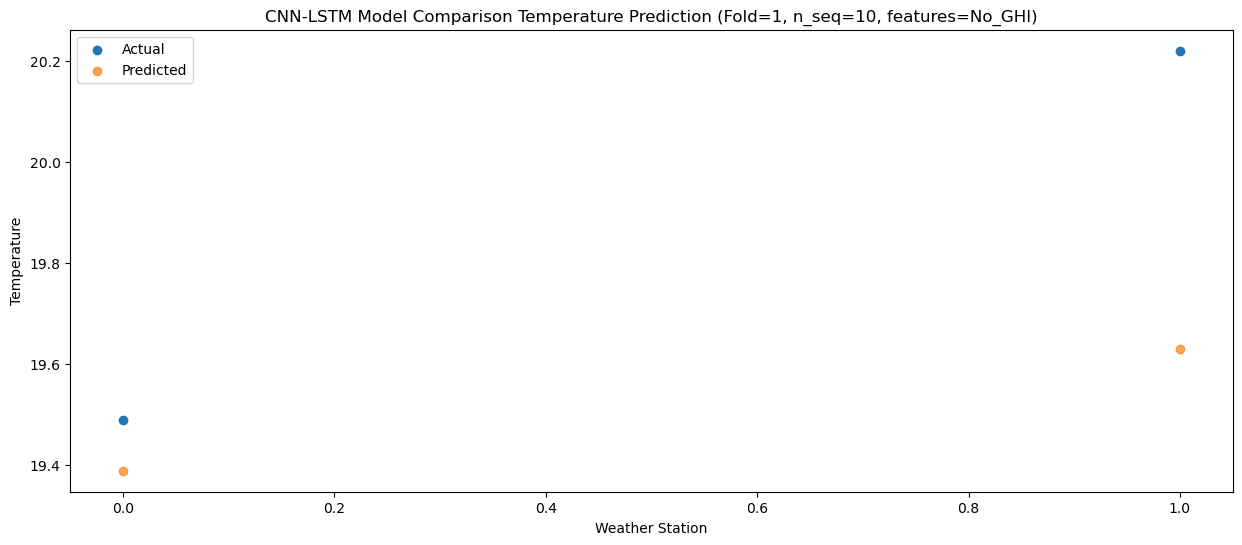

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   19.83  19.101482
1                1   20.22  18.887884


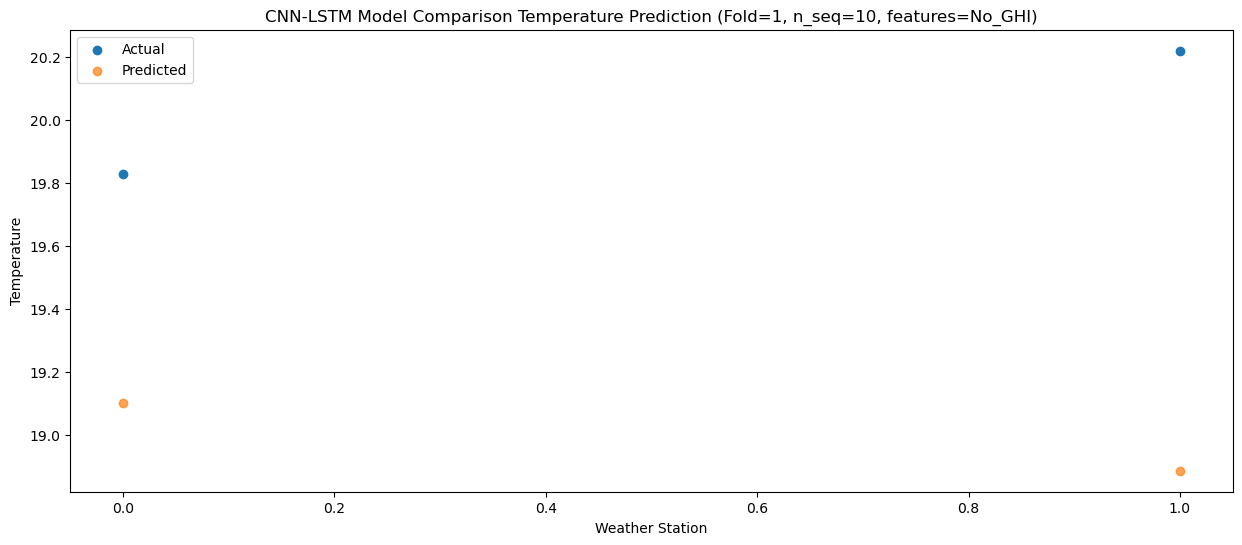

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   20.67  19.572066
1                1   21.53  19.256872


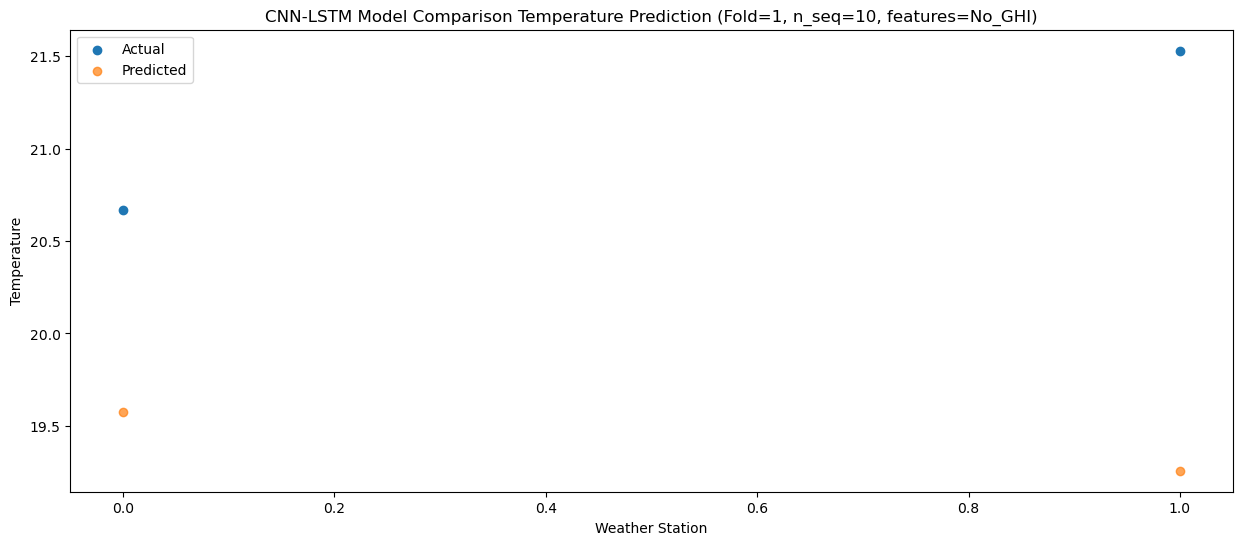

f, t:
[[19.63 19.88]
 [20.16 19.4 ]
 [20.45 20.43]
 [20.41 20.81]
 [20.24 19.96]
 [20.32 20.09]
 [20.41 20.61]
 [19.49 20.22]
 [19.83 20.22]
 [20.67 21.53]]
[[18.83810822 19.45626571]
 [19.71683029 20.08957412]
 [20.63609485 20.68087091]
 [20.32399295 20.02989538]
 [19.74068902 19.78036337]
 [19.69994107 19.05663137]
 [19.60352215 19.72993134]
 [19.38931474 19.62968259]
 [19.10148221 18.88788395]
 [19.57206577 19.2568724 ]]
Year at t+1:
t+1 SKRMSE: 0.635076
t+1 KRMSE: 0.635076
t+1 MAE: 0.607813
t+1 SKMAPE: 0.030828
t+1 R2_SCORE: -24.812587
t+1 KMAPE: 0.030828
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.579617
t+2 KRMSE: 0.579617
t+2 MAE: 0.566372
t+2 SKMAPE: 0.028764
t+2 R2_SCORE: -1.326565
t+2 KMAPE: 0.028764
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.220870
t+3 KRMSE: 0.220870
t+3 MAE: 0.218483
t+3 SKMAPE: 0.010690
t+3 R2_SCORE: -486.837522
t+3 KMAPE: 0.010690
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.554960
t+4 KRMSE: 0.554960
t+4 MAE: 0.433056
t+4 SKMAPE: 0.020850

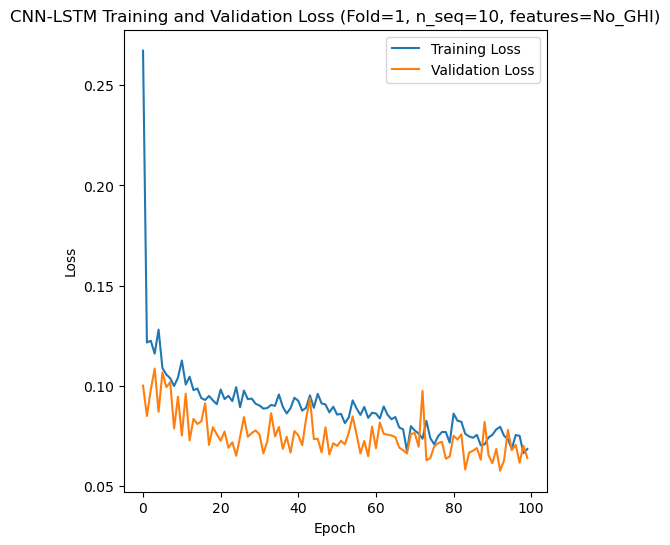

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 41s 595ms/step - loss: 0.2618 - accuracy: 0.3158 - mae: 0.2305 - rmse: 0.2618 - mape: 37.0805 - pearson: 0.3762 - val_loss: 0.1471 - val_accuracy: 0.3333 - val_mae: 0.1301 - val_rmse: 0.1471 - val_mape: 21.7223 - val_pearson: 0.0523
Epoch 2/100
19/19 [==============================] - 4s 192ms/step - loss: 0.1364 - accuracy: 0.2105 - mae: 0.1121 - rmse: 0.1364 - mape: 18.6691 - pearson: 0.3446 - val_loss: 0.0896 - val_accuracy: 0.0000e+00 - val_mae: 0.0733 - val_rmse: 0.0896 - val_mape: 12.1253 - val_pearson: 0.3665
Epoch 3/100
19/19 [==============================] - 4s 186ms/step - loss: 0.1333 - acc

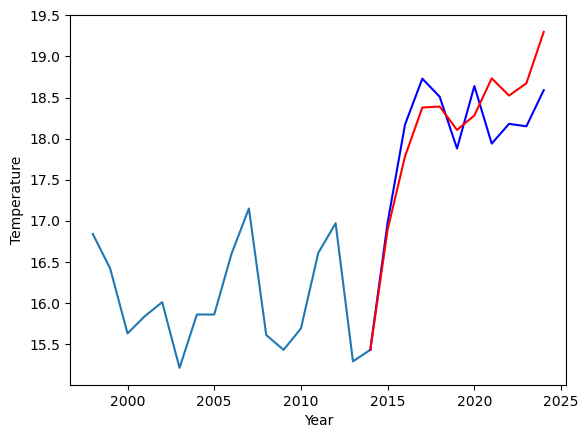

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.89		13.18		0.29
14.23		14.67		0.44
15.00		15.44		0.44
14.82		15.09		0.27
14.35		14.65		0.30
14.68		14.45		-0.23
14.67		15.44		0.77
14.66		15.49		0.83
14.20		15.02		0.82
14.99		15.97		0.98


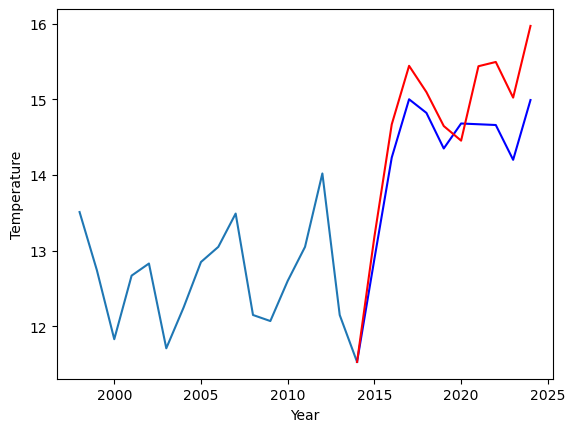

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.98  16.893511
1                1   12.89  13.183918


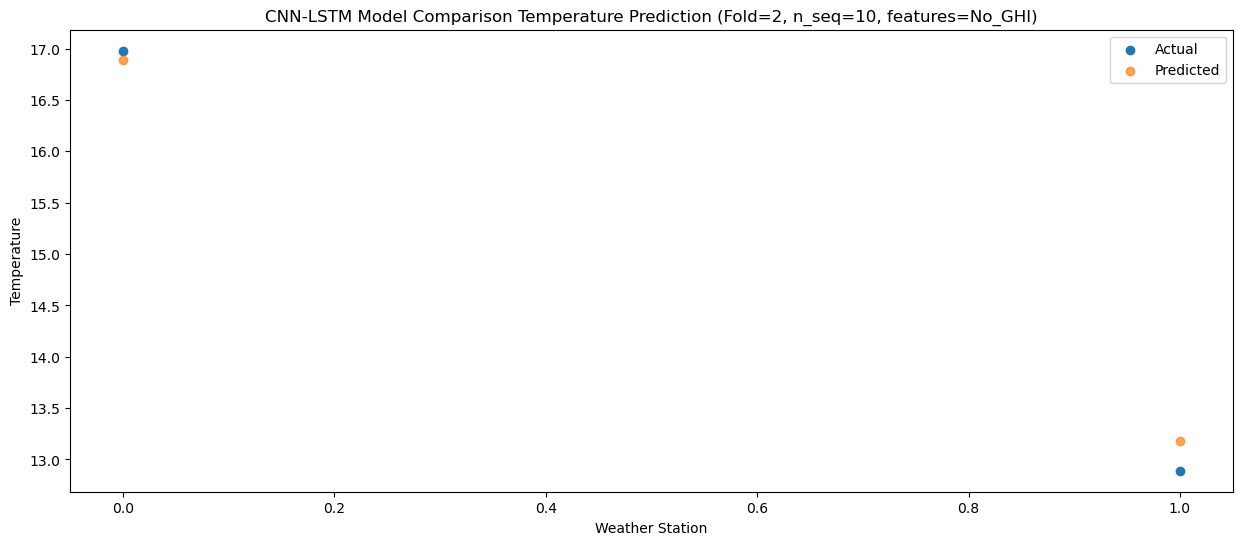

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   18.17  17.782738
1                1   14.23  14.668082


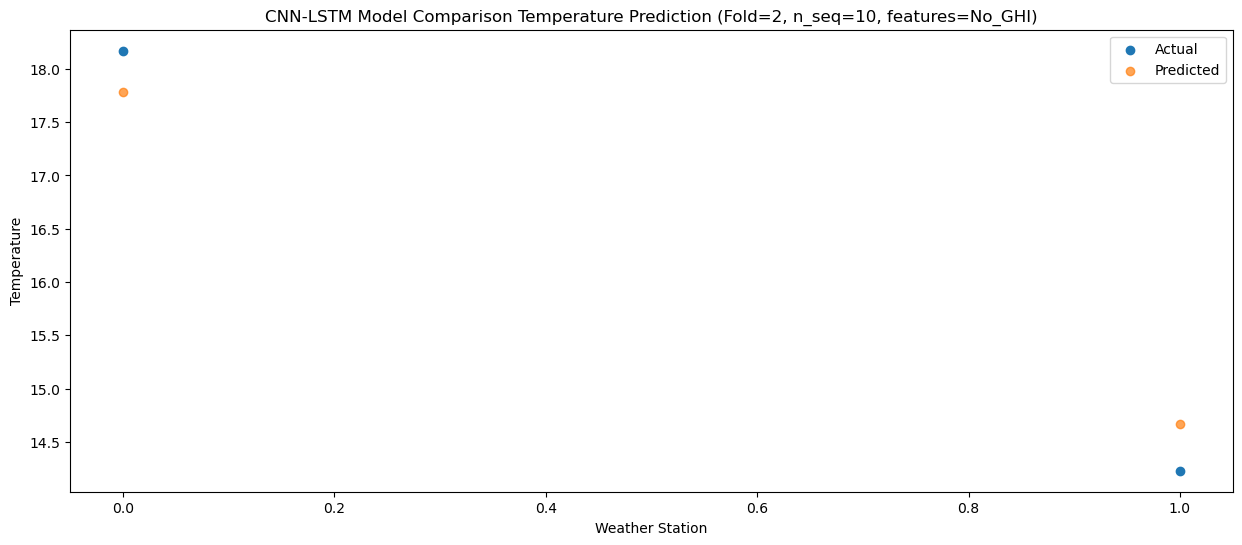

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.73  18.378537
1                1   15.00  15.441949


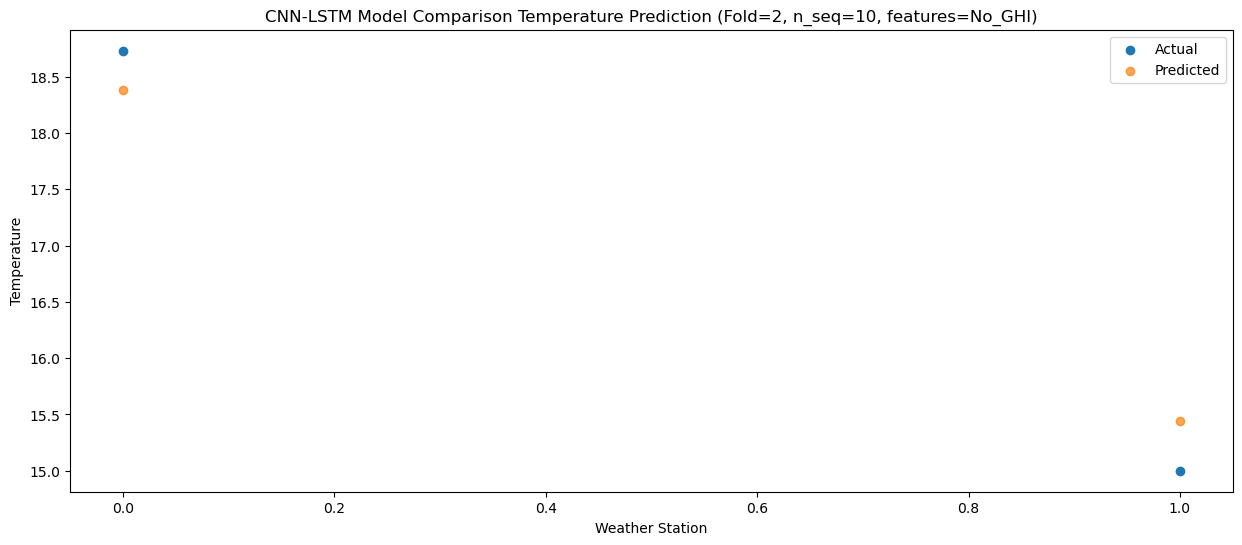

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   18.51  18.390561
1                1   14.82  15.094725


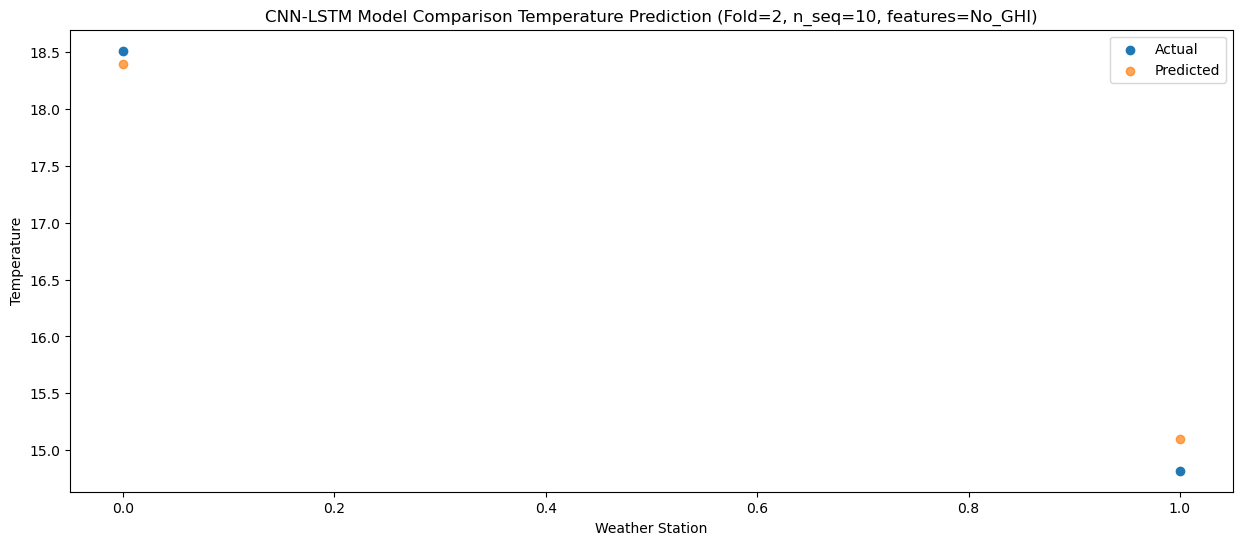

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.88  18.106114
1                1   14.35  14.646346


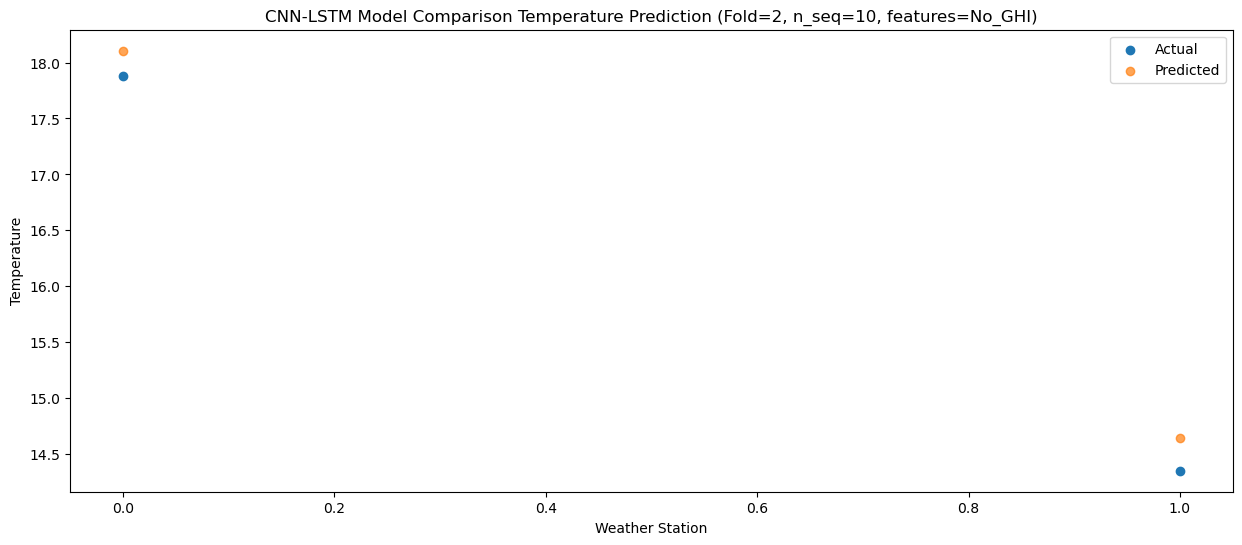

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   18.64  18.282238
1                1   14.68  14.453422


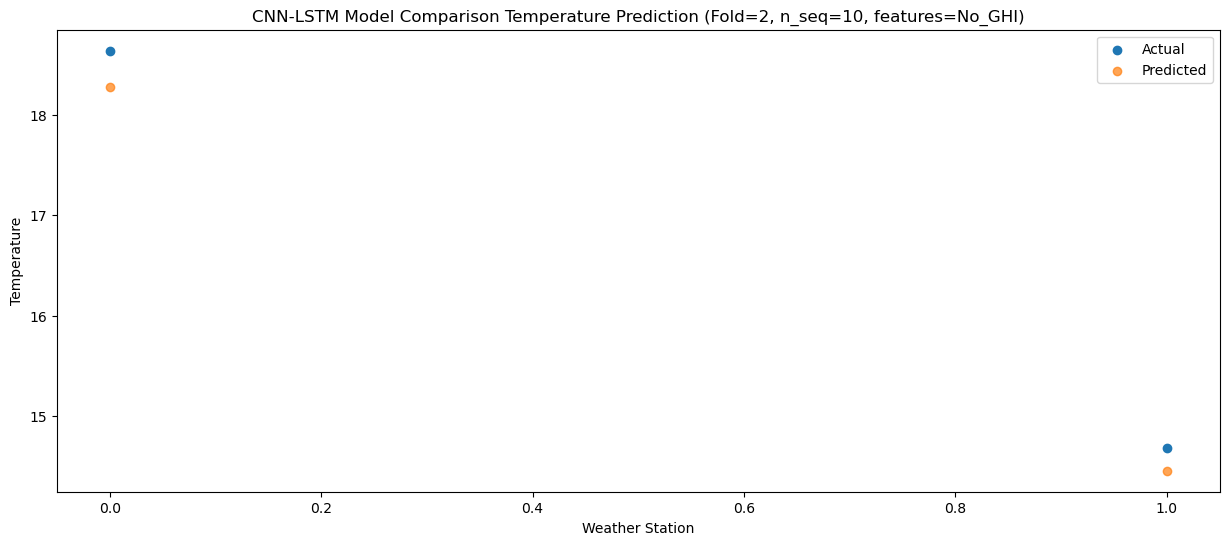

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   17.94  18.733883
1                1   14.67  15.436576


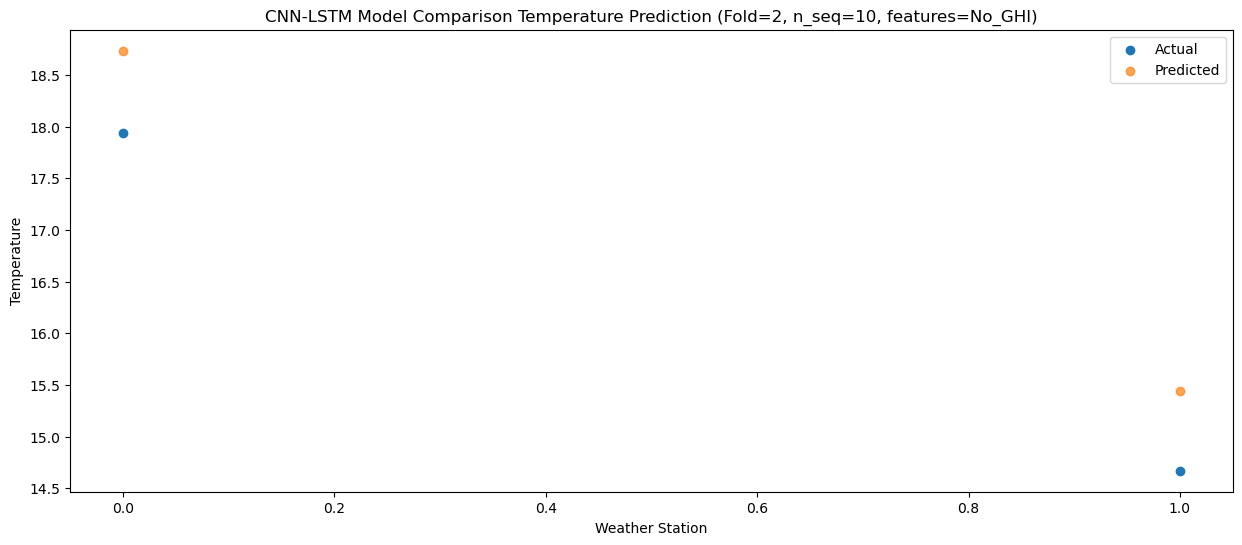

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   18.18  18.523768
1                1   14.66  15.492924


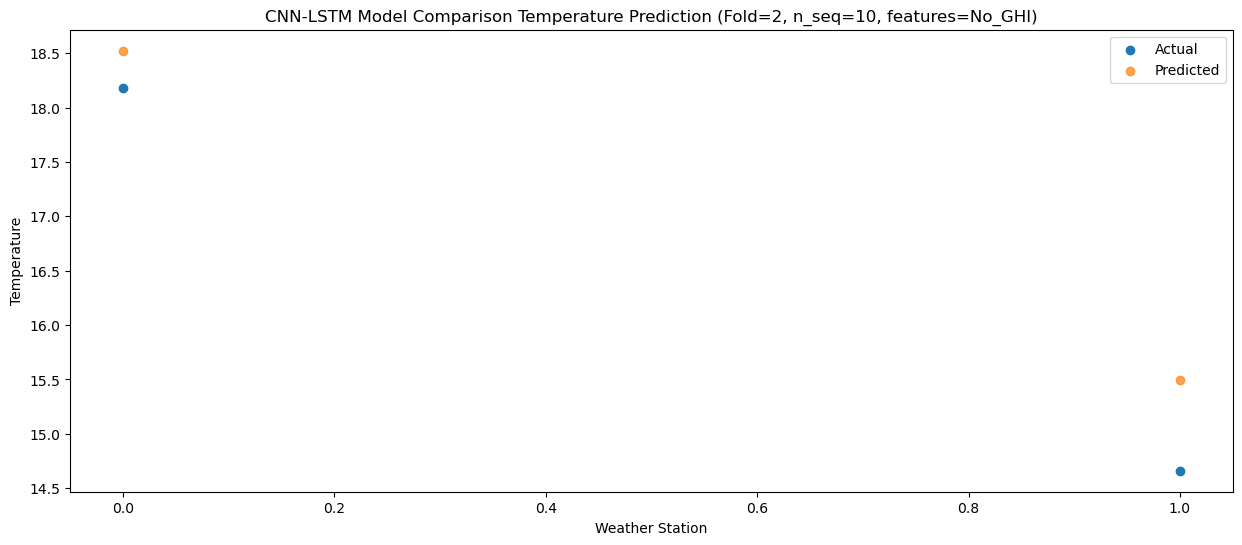

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   18.15  18.673828
1                1   14.20  15.021877


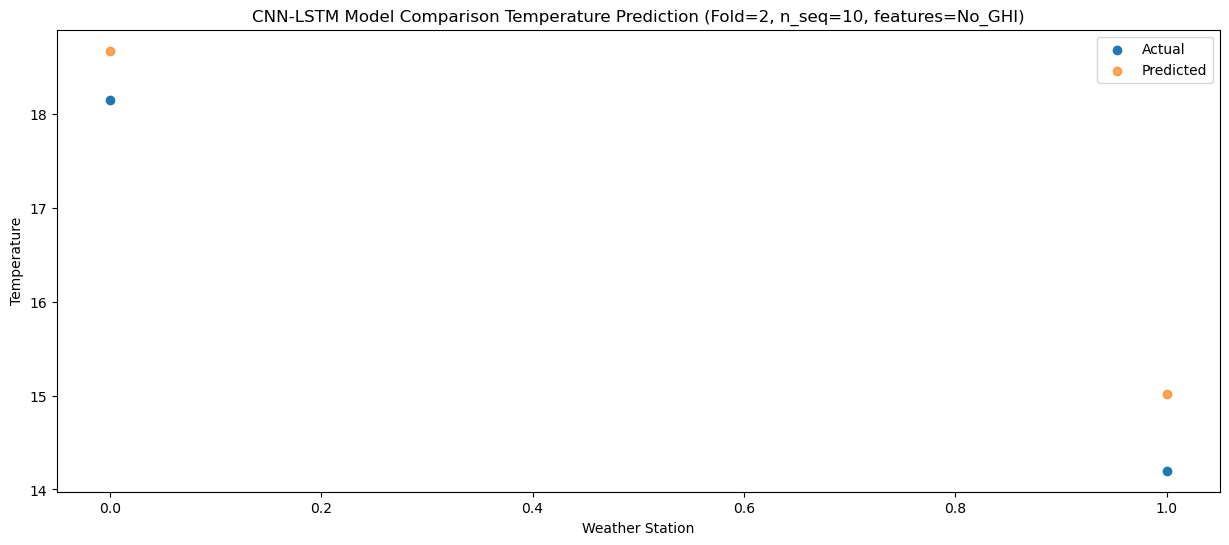

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   18.59  19.298632
1                1   14.99  15.969115


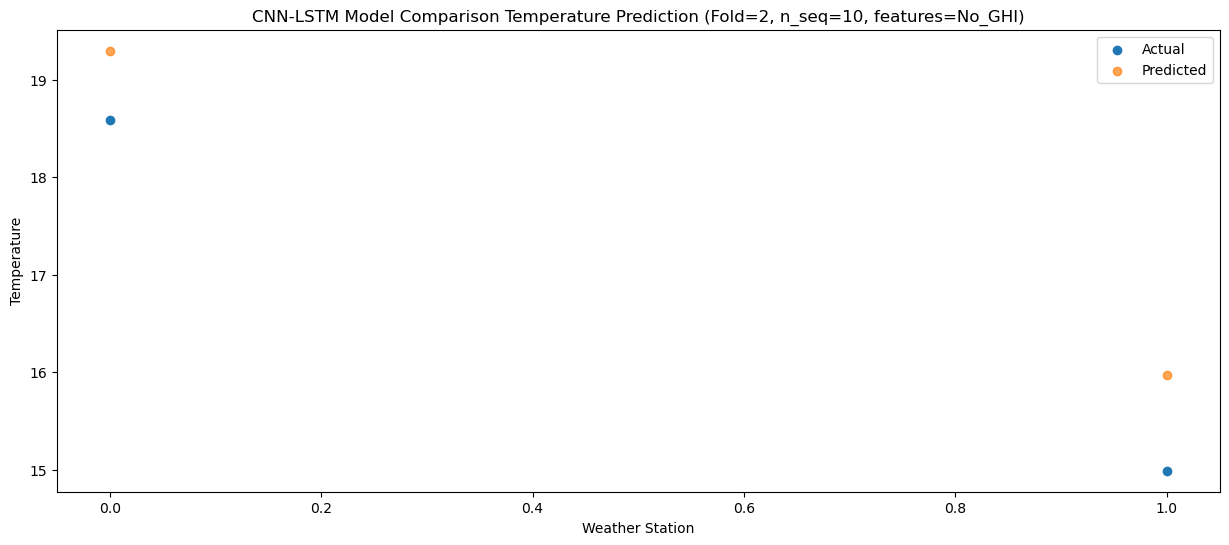

f, t:
[[16.98 12.89]
 [18.17 14.23]
 [18.73 15.  ]
 [18.51 14.82]
 [17.88 14.35]
 [18.64 14.68]
 [17.94 14.67]
 [18.18 14.66]
 [18.15 14.2 ]
 [18.59 14.99]]
[[16.89351055 13.18391816]
 [17.7827377  14.66808204]
 [18.37853739 15.44194899]
 [18.39056086 15.09472517]
 [18.1061142  14.64634649]
 [18.28223759 14.45342203]
 [18.733883   15.43657621]
 [18.5237681  15.49292421]
 [18.67382785 15.02187699]
 [19.29863187 15.9691149 ]]
Year at t+1:
t+1 SKRMSE: 0.216643
t+1 KRMSE: 0.216643
t+1 MAE: 0.190204
t+1 SKMAPE: 0.013948
t+1 R2_SCORE: 0.988777
t+1 KMAPE: 0.013948
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.413454
t+2 KRMSE: 0.413454
t+2 MAE: 0.412672
t+2 SKMAPE: 0.026050
t+2 R2_SCORE: 0.955952
t+2 KMAPE: 0.026050
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.399277
t+3 KRMSE: 0.399277
t+3 MAE: 0.396706
t+3 SKMAPE: 0.024114
t+3 R2_SCORE: 0.954166
t+3 KMAPE: 0.024114
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.211825
t+4 KRMSE: 0.211825
t+4 MAE: 0.197082
t+4 SKMAPE: 0.012495
t+4 R

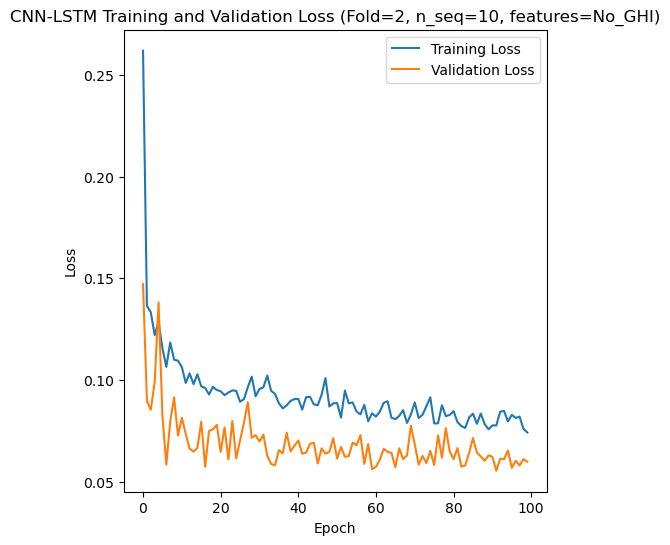

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 41s 625ms/step - loss: 0.2358 - accuracy: 0.3000 - mae: 0.2071 - rmse: 0.2358 - mape: 32.1986 - pearson: 0.2770 - val_loss: 0.1991 - val_accuracy: 1.0000 - val_mae: 0.1649 - val_rmse: 0.1991 - val_mape: 22.2171 - val_pearson: 0.6694
Epoch 2/100
20/20 [==============================] - 4s 177ms/step - loss: 0.1409 - accuracy: 0.3000 - mae: 0.1174 - rmse: 0.1409 - mape: 18.6860 - pearson: 0.3232 - val_loss: 0.1709 - val_accuracy: 0.0000e+00 - val_mae: 0.1372 - val_rmse: 0.1709 - val_mape: 25.0199 - val_pearson: 0.4260
Epoch 3/100
20/20 [==============================] - 4s 186ms/step - loss: 0.1259 - accu

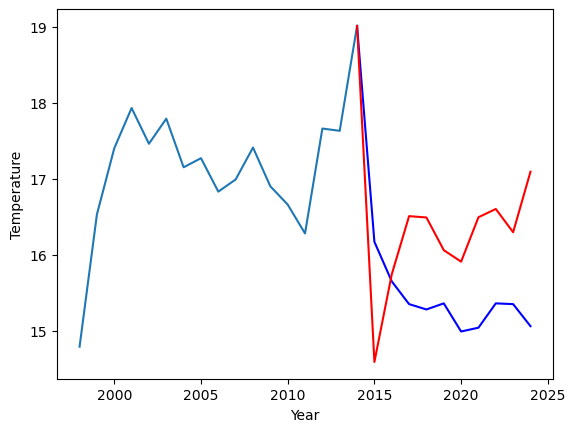

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.03		13.86		0.83
14.13		15.01		0.88
15.42		15.78		0.36
15.25		15.76		0.51
14.76		15.33		0.57
15.17		15.18		0.01
15.05		15.76		0.71
14.85		15.87		1.02
14.55		15.56		1.01
15.57		16.36		0.79


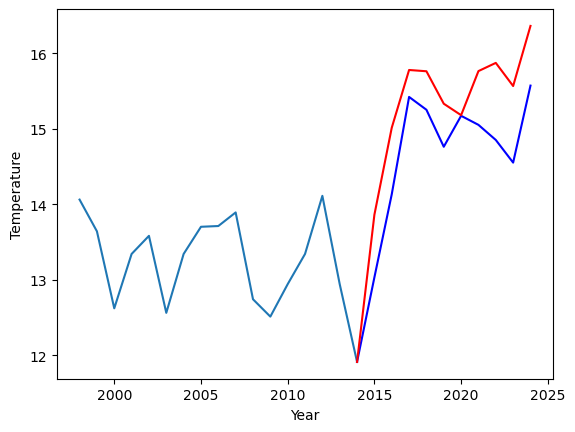

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.17  14.589709
1                1   13.03  13.859815


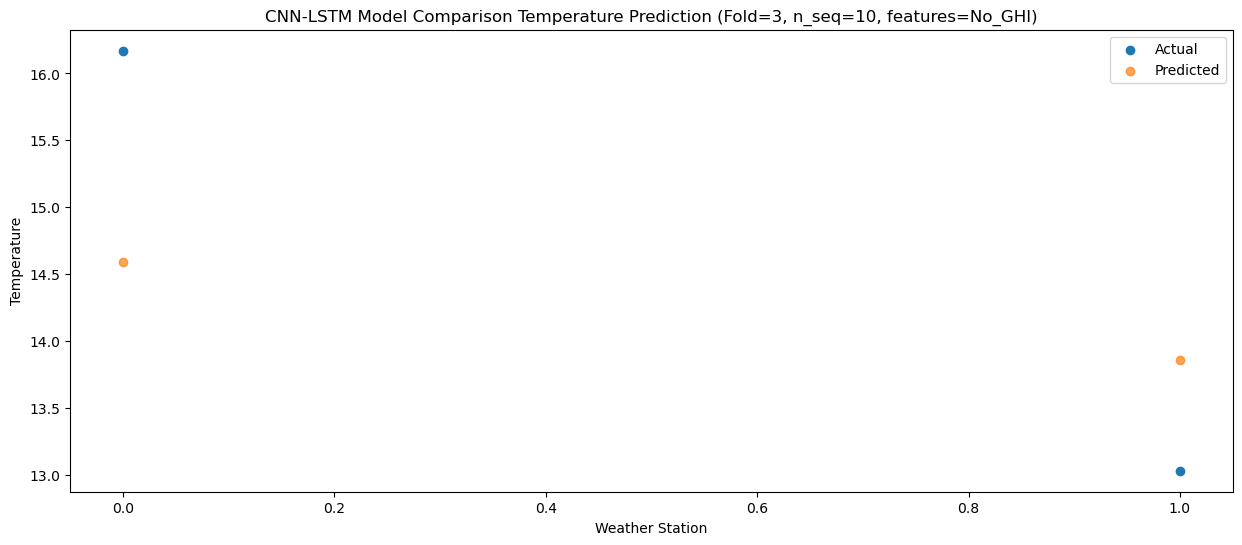

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   15.65  15.741569
1                1   14.13  15.011267


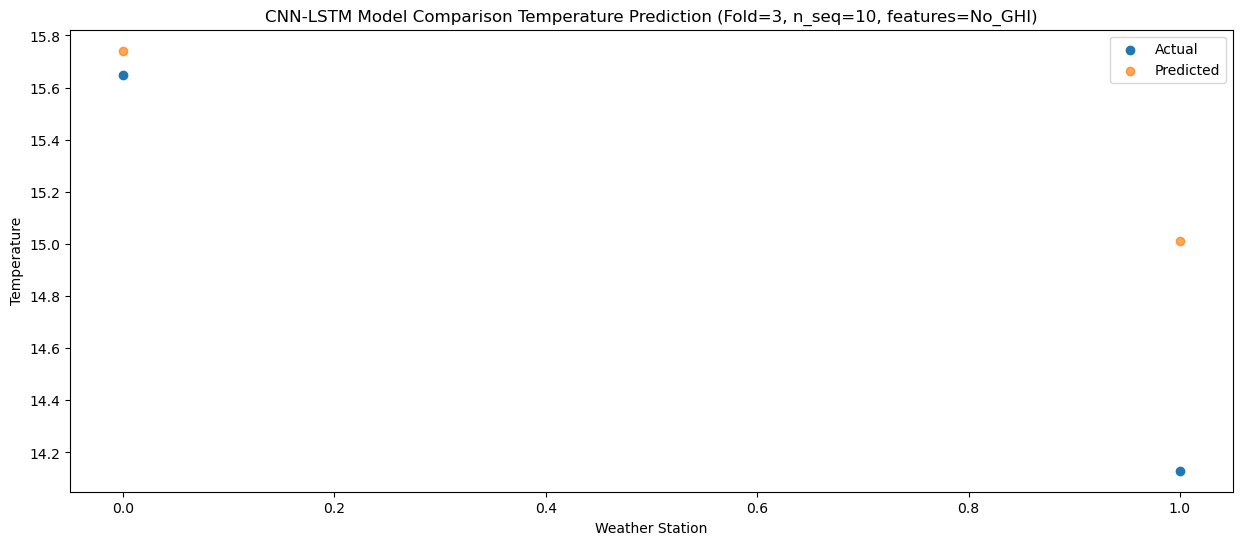

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   15.35  16.507377
1                1   15.42  15.776851


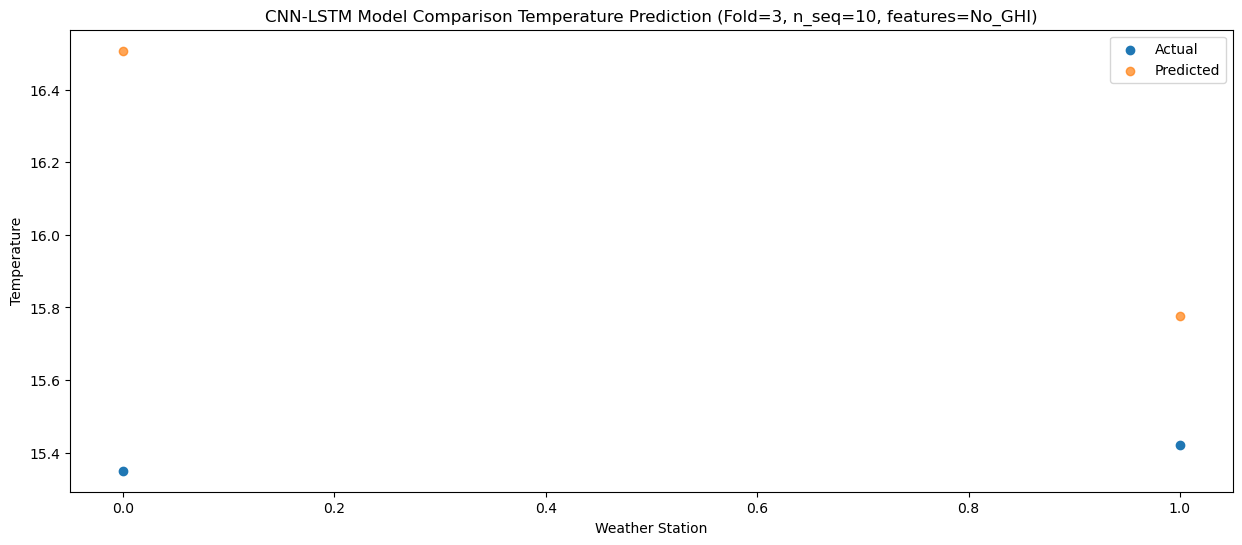

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   15.28  16.490132
1                1   15.25  15.759962


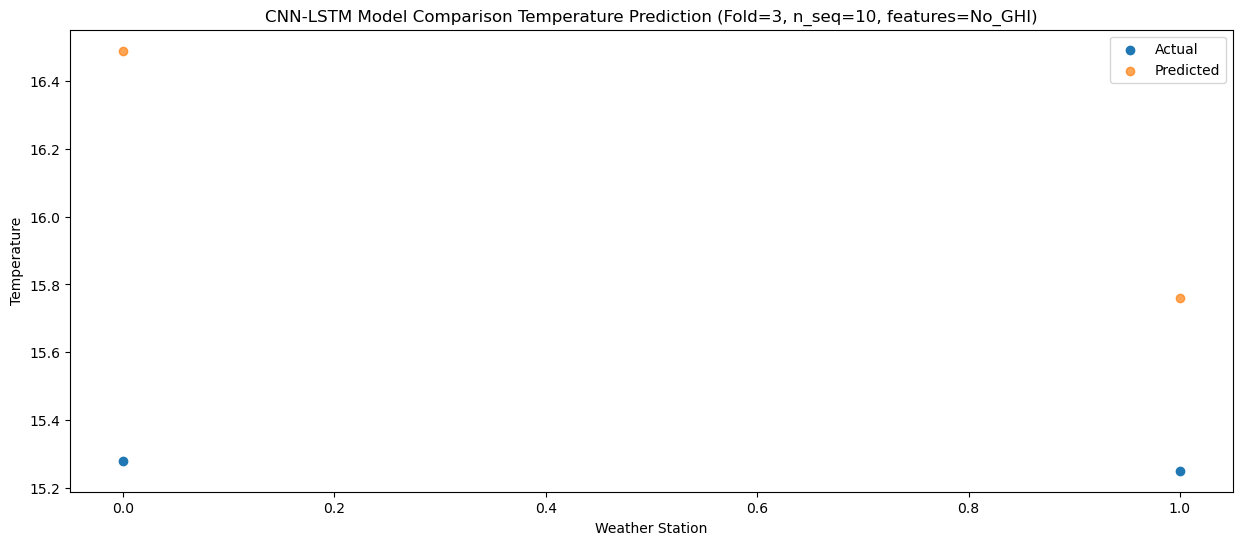

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   15.36  16.060056
1                1   14.76  15.330053


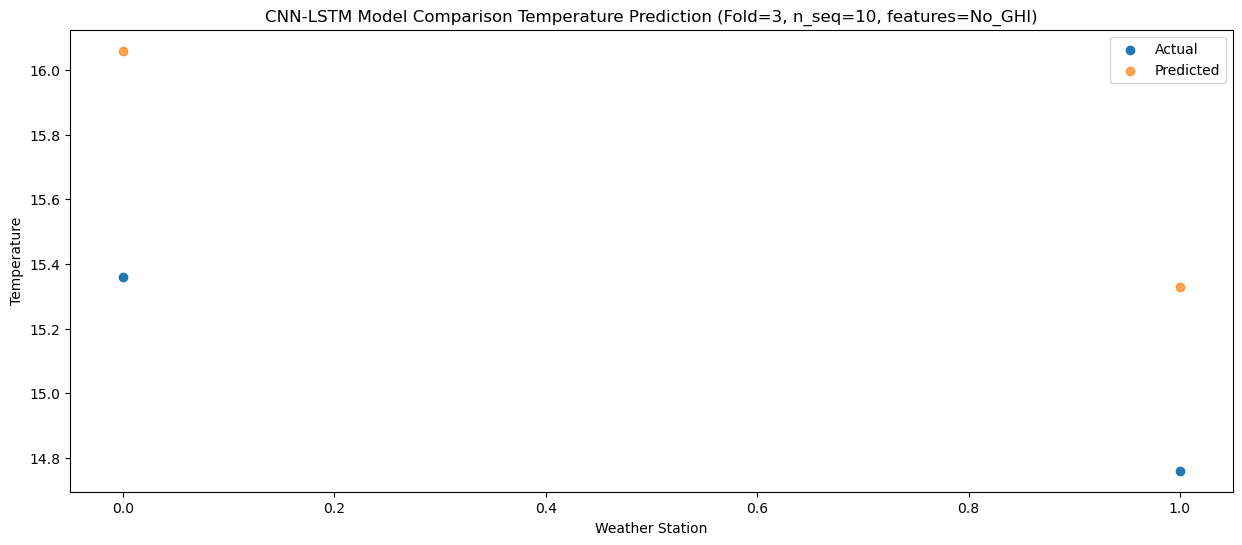

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   14.99  15.908551
1                1   15.17  15.178116


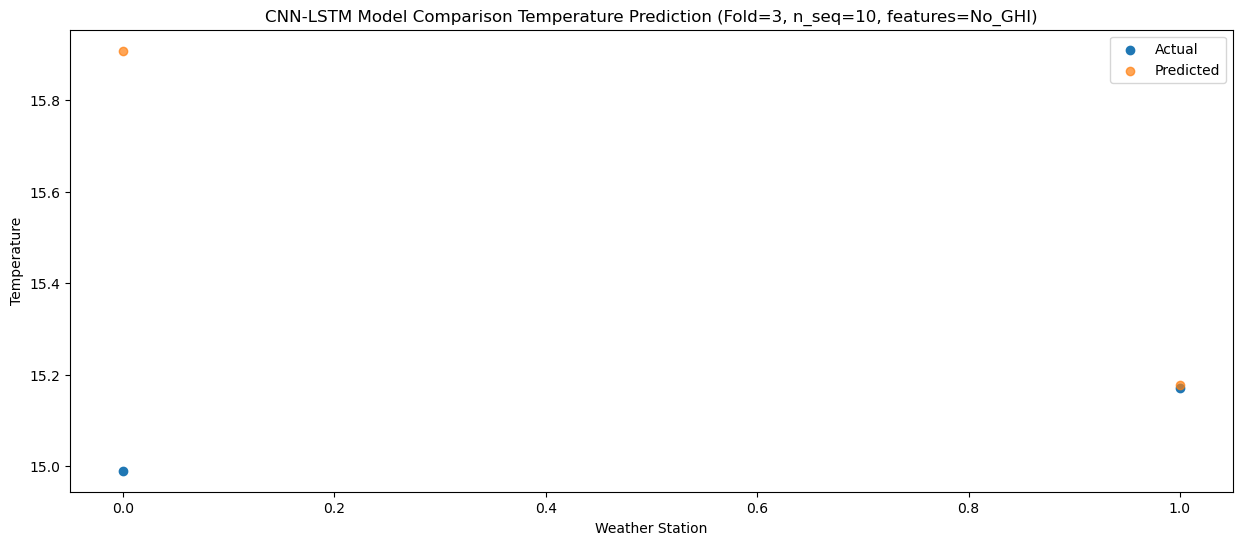

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   15.04  16.493142
1                1   15.05  15.762368


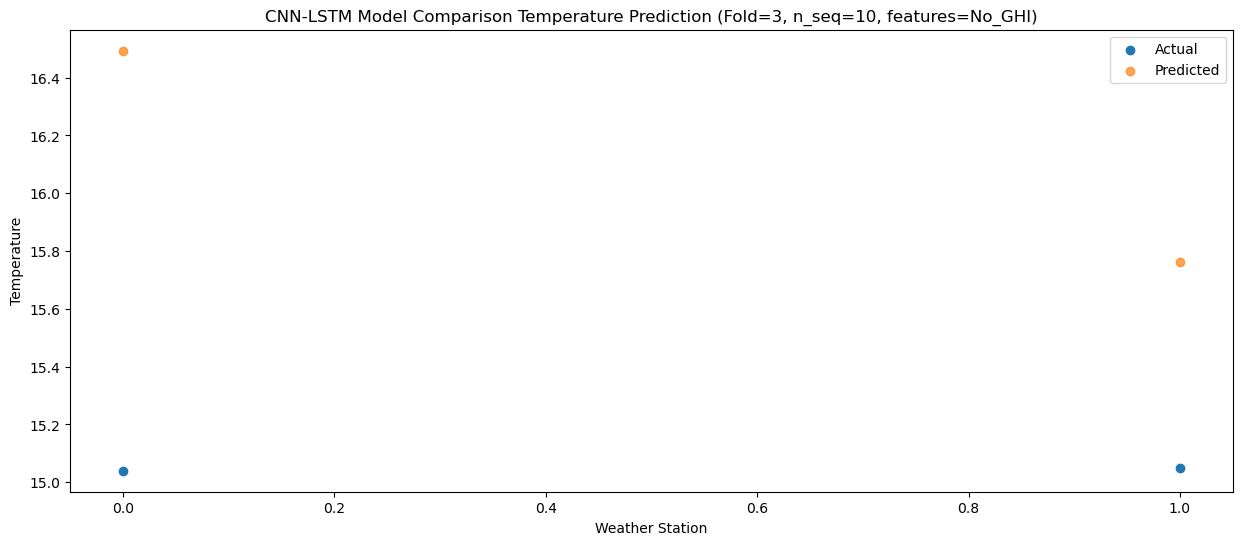

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   15.36  16.601789
1                1   14.85  15.870767


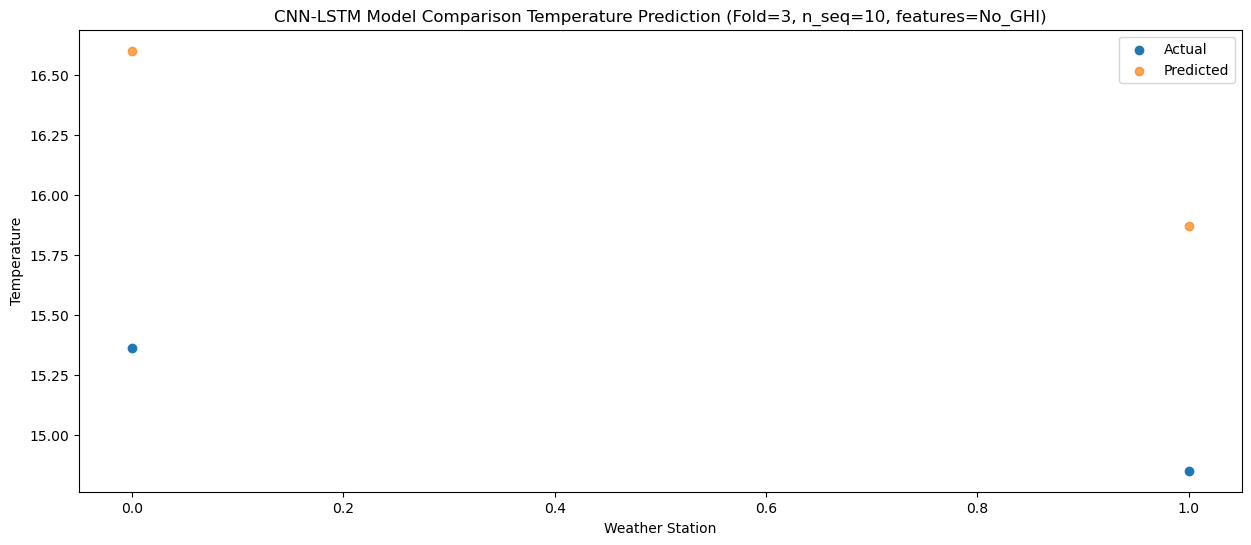

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   15.35  16.295774
1                1   14.55  15.564338


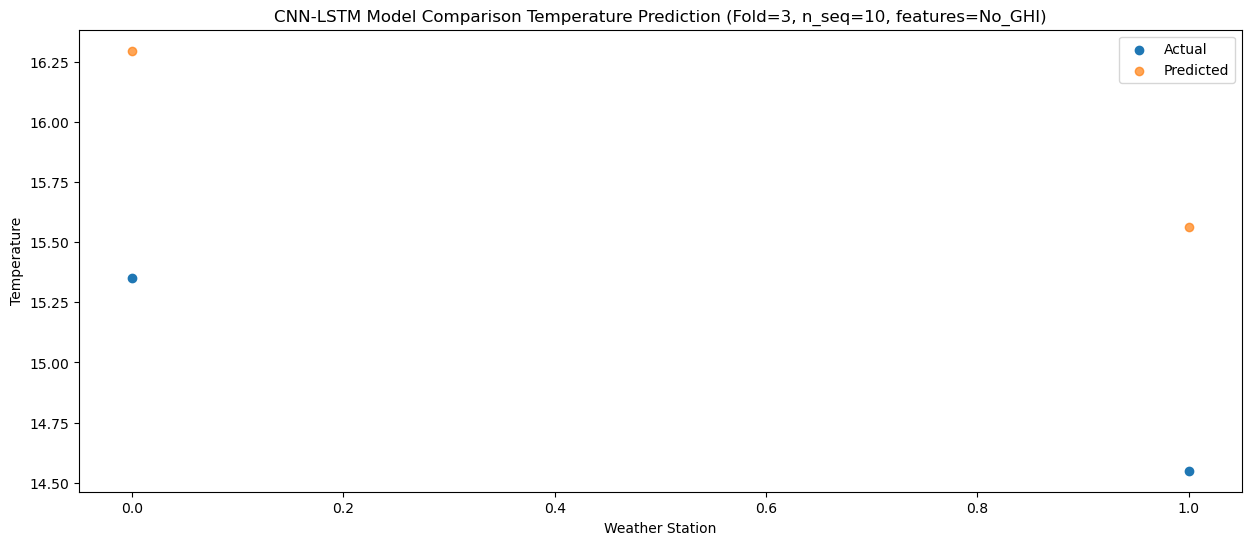

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   15.06  17.092214
1                1   15.57  16.360521


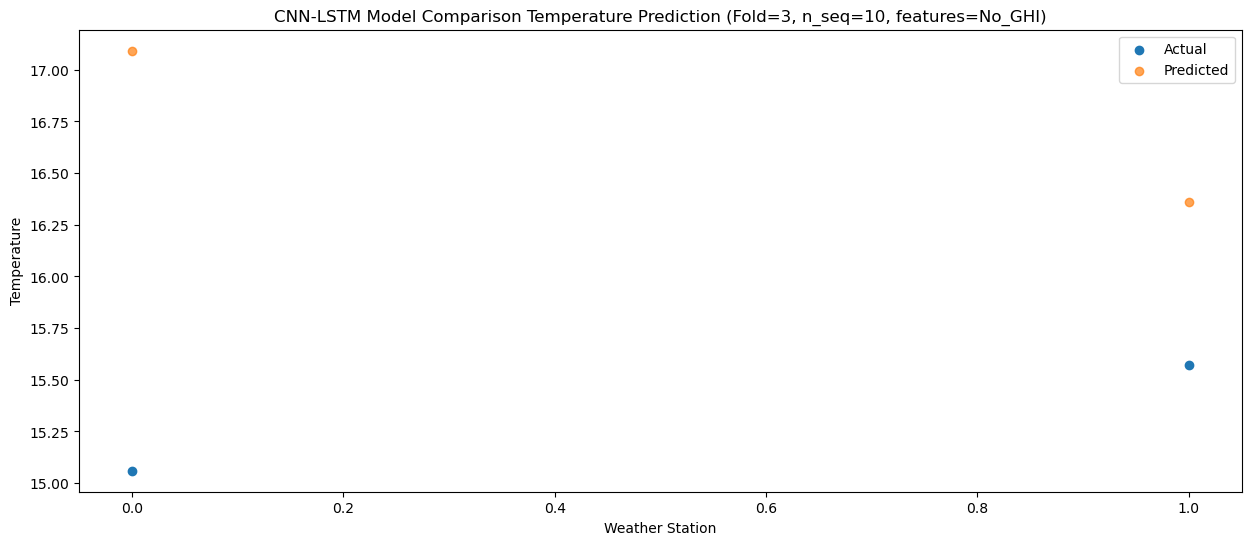

f, t:
[[16.17 13.03]
 [15.65 14.13]
 [15.35 15.42]
 [15.28 15.25]
 [15.36 14.76]
 [14.99 15.17]
 [15.04 15.05]
 [15.36 14.85]
 [15.35 14.55]
 [15.06 15.57]]
[[14.5897091  13.8598153 ]
 [15.74156886 15.01126736]
 [16.50737702 15.77685058]
 [16.49013172 15.75996236]
 [16.0600559  15.33005271]
 [15.90855072 15.1781163 ]
 [16.49314205 15.762368  ]
 [16.60178897 15.87076727]
 [16.29577374 15.56433782]
 [17.09221417 16.36052129]]
Year at t+1:
t+1 SKRMSE: 1.262124
t+1 KRMSE: 1.262124
t+1 MAE: 1.205053
t+1 SKMAPE: 0.080707
t+1 R2_SCORE: 0.353744
t+1 KMAPE: 0.080707
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.626505
t+2 KRMSE: 0.626505
t+2 MAE: 0.486418
t+2 SKMAPE: 0.034110
t+2 R2_SCORE: 0.320449
t+2 KMAPE: 0.034110
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.856406
t+3 KRMSE: 0.856406
t+3 MAE: 0.757114
t+3 SKMAPE: 0.049271
t+3 R2_SCORE: -597.719962
t+3 KMAPE: 0.049271
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.928569
t+4 KRMSE: 0.928569
t+4 MAE: 0.860047
t+4 SKMAPE: 0.056319
t+

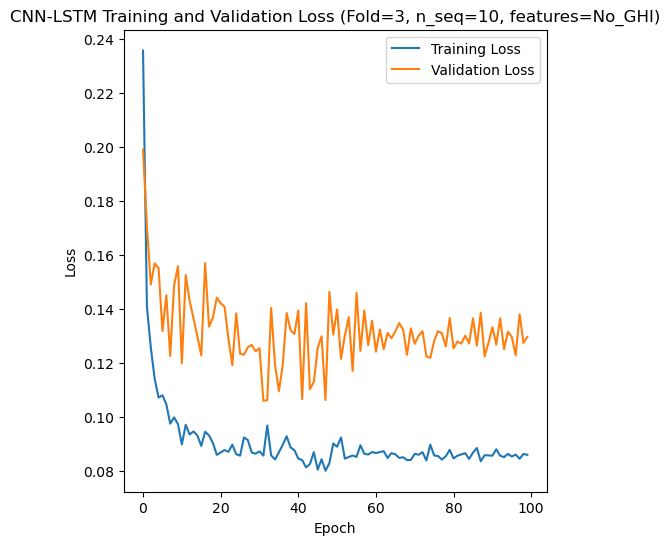

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 31s 506ms/step - loss: 0.2552 - accuracy: 0.1579 - mae: 0.2254 - rmse: 0.2552 - mape: 36.1850 - pearson: 0.1813 - val_loss: 0.1783 - val_accuracy: 0.0000e+00 - val_mae: 0.1459 - val_rmse: 0.1783 - val_mape: 22.3925 - val_pearson: 0.3153
Epoch 2/100
19/19 [==============================] - 3s 164ms/step - loss: 0.1332 - accuracy: 0.4211 - mae: 0.1101 - rmse: 0.1332 - mape: 17.9183 - pearson: 0.3327 - val_loss: 0.1472 - val_accuracy: 0.0000e+00 - val_mae: 0.1277 - val_rmse: 0.1472 - val_mape: 24.3901 - val_pearson: 0.6012
Epoch 3/100
19/19 [==============================] - 3s 177ms/step - loss: 0.1321 

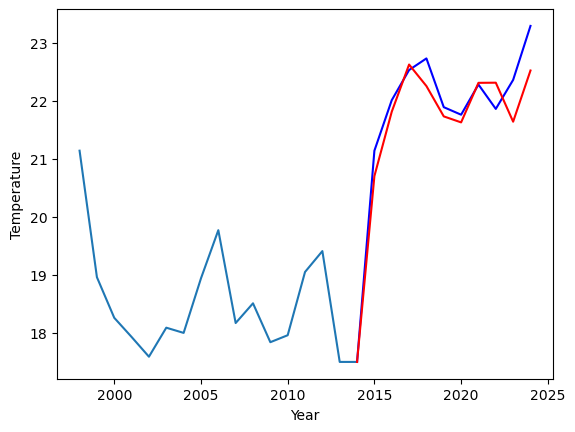

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.63		12.52		-0.11
14.58		13.60		-0.98
15.60		14.38		-1.22
15.53		13.99		-1.54
14.23		13.46		-0.77
13.53		13.32		-0.21
14.09		14.03		-0.06
14.41		14.04		-0.37
13.54		13.33		-0.21
15.02		14.21		-0.81


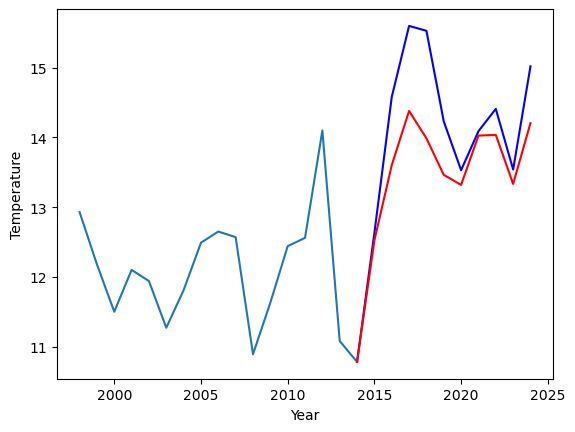

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.14  20.702444
1                1   12.63  12.523858


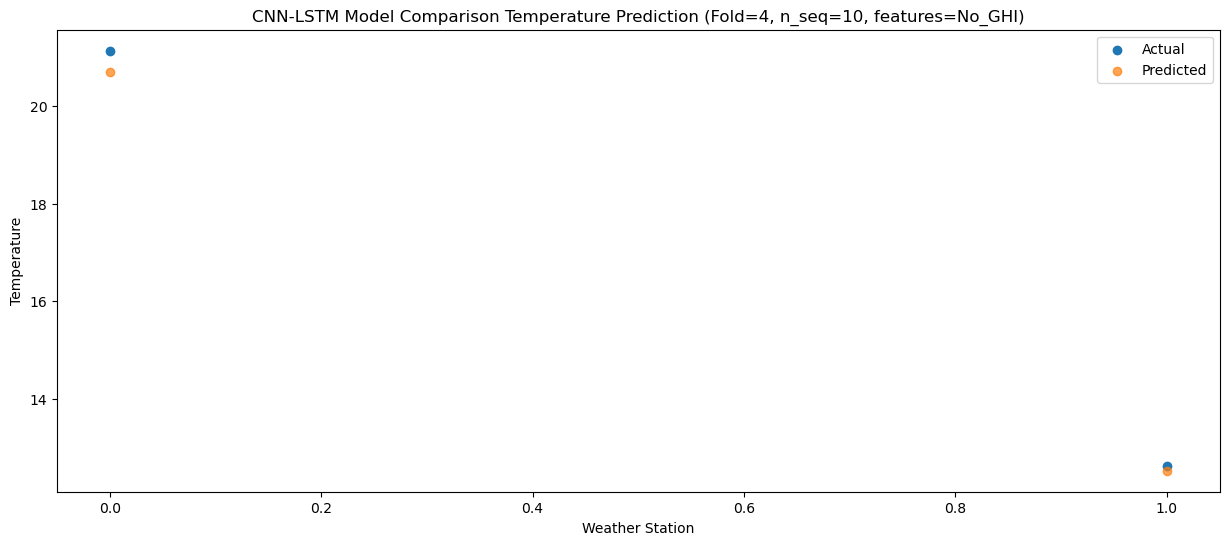

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   22.01  21.810883
1                1   14.58  13.601679


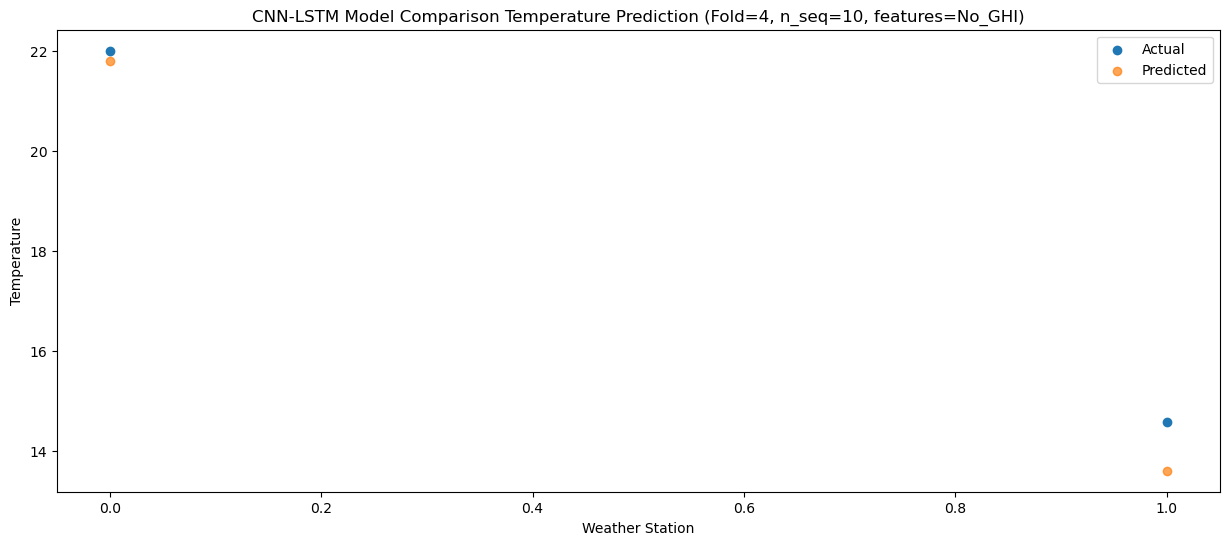

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.53  22.624569
1                1   15.60  14.380370


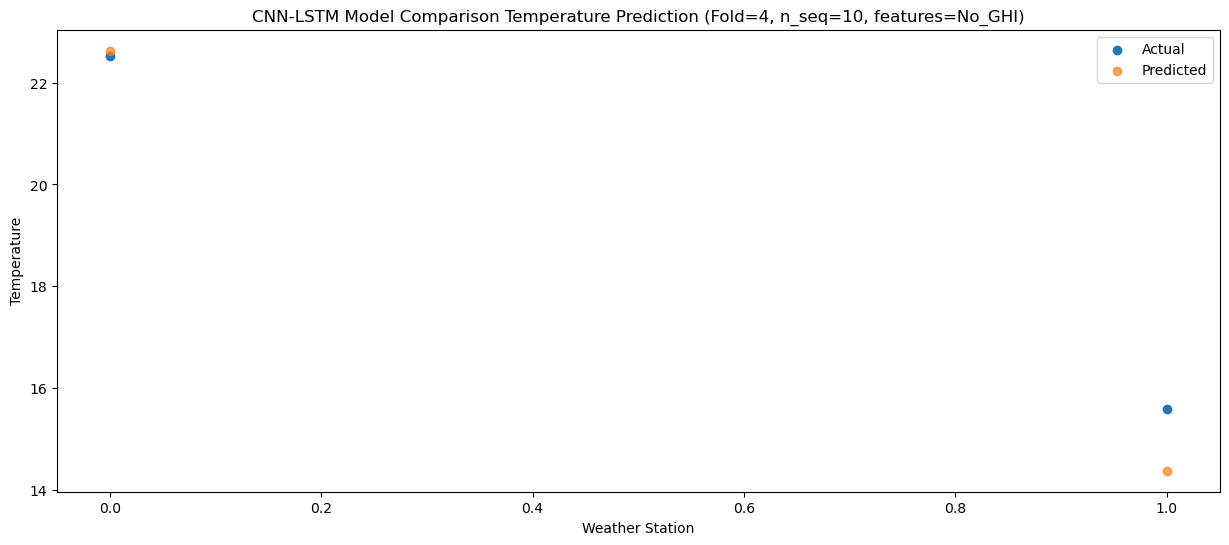

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.73  22.253502
1                1   15.53  13.987656


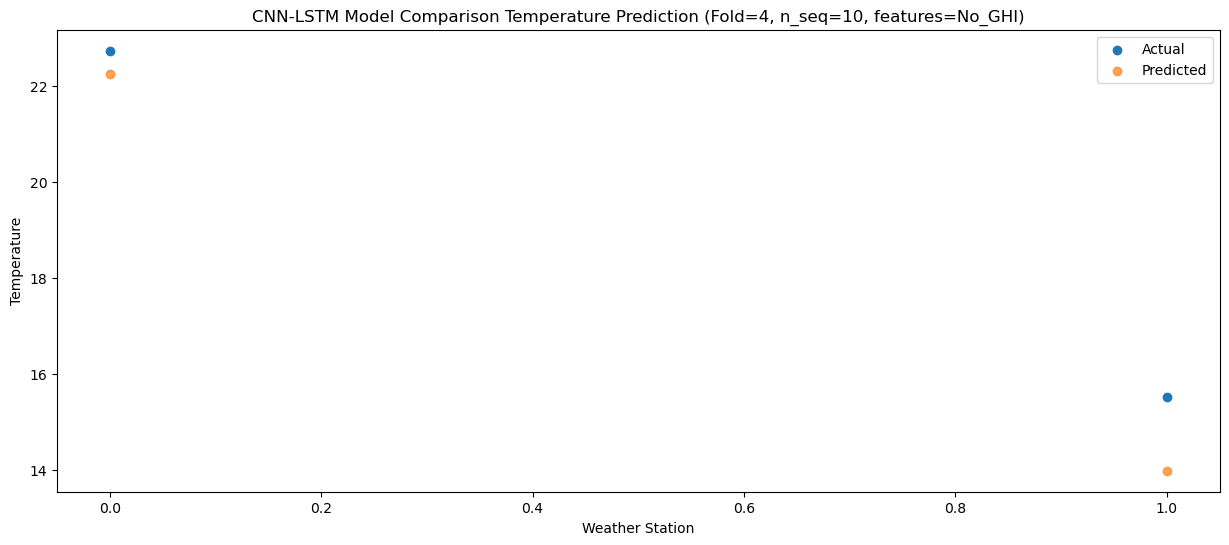

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.89  21.731073
1                1   14.23  13.463466


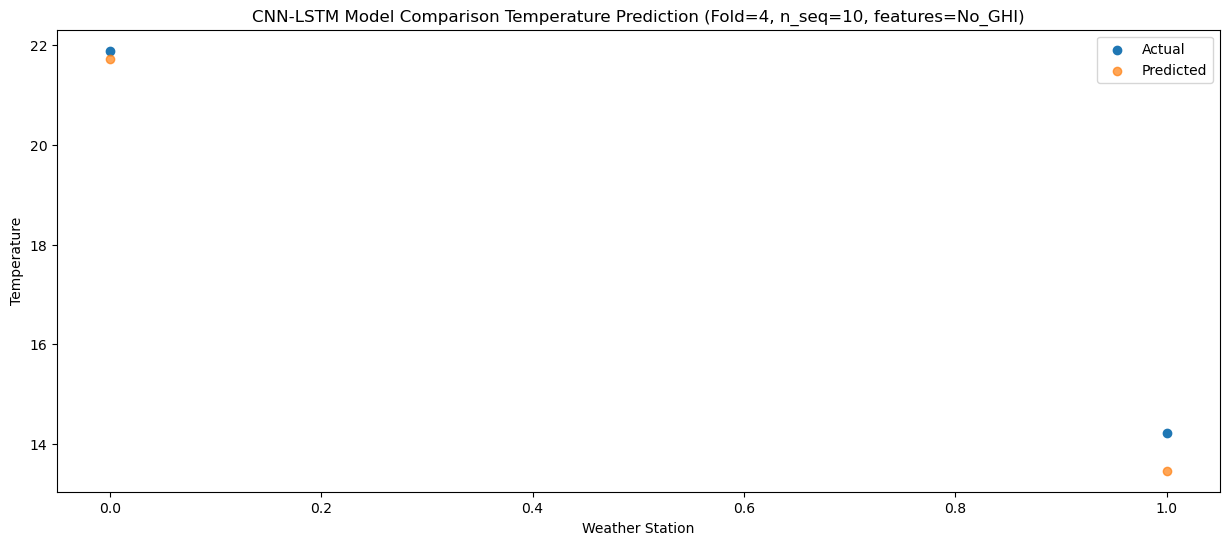

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.76  21.627736
1                1   13.53  13.318871


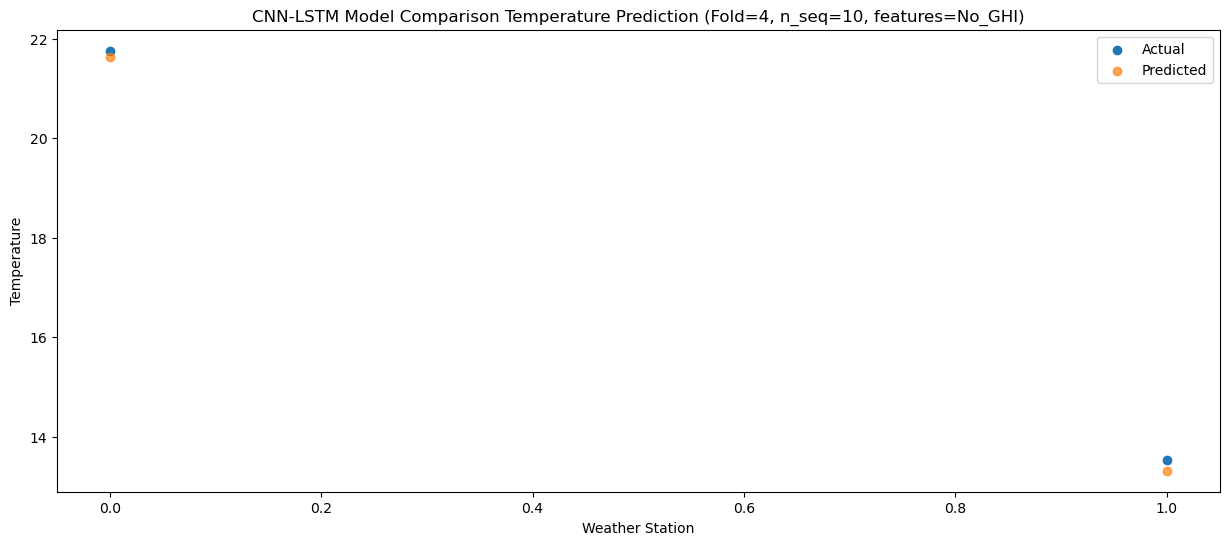

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   22.28  22.309269
1                1   14.09  14.026574


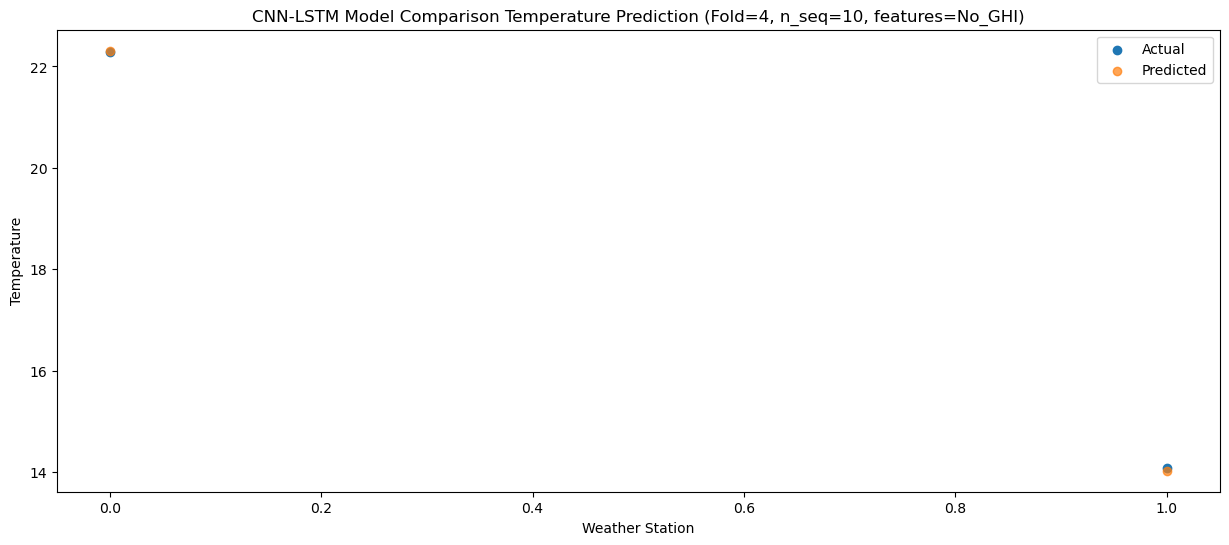

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.86  22.311710
1                1   14.41  14.037356


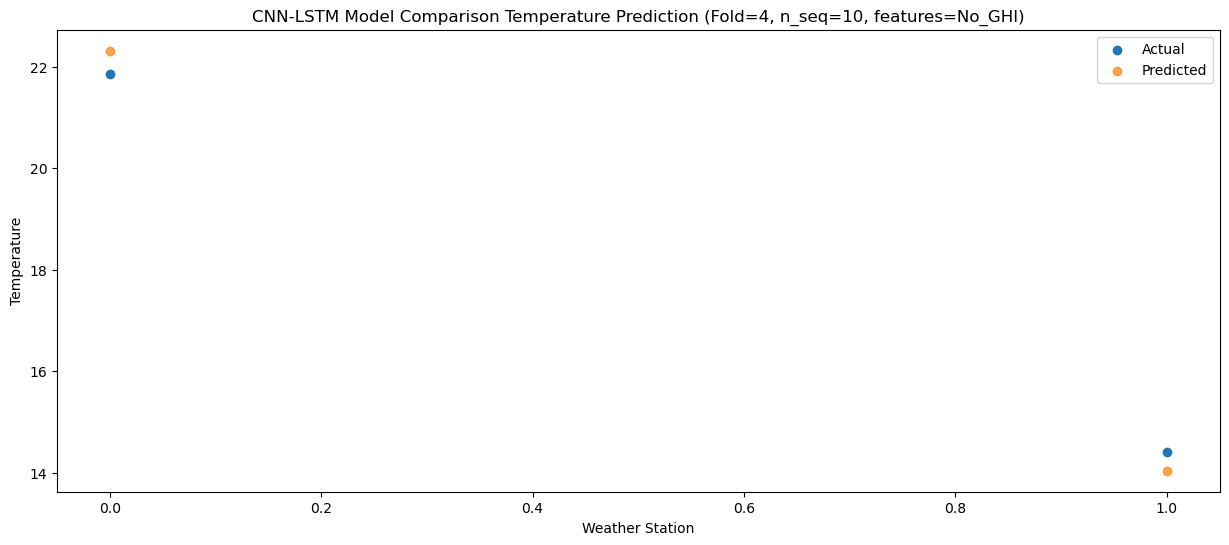

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   22.36  21.639658
1                1   13.54  13.333630


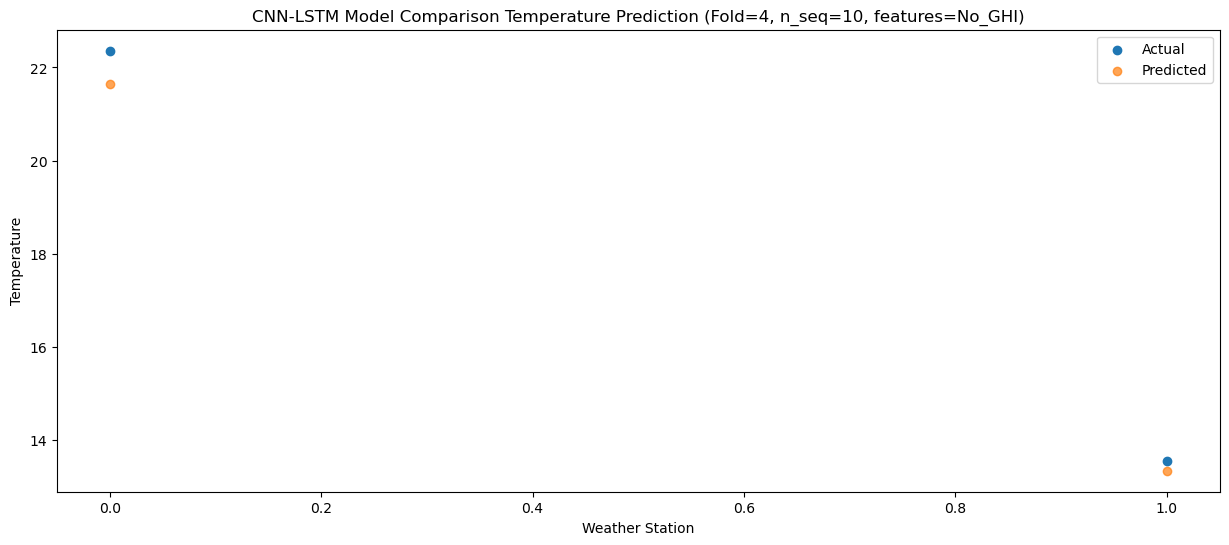

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   23.29  22.521689
1                1   15.02  14.205583


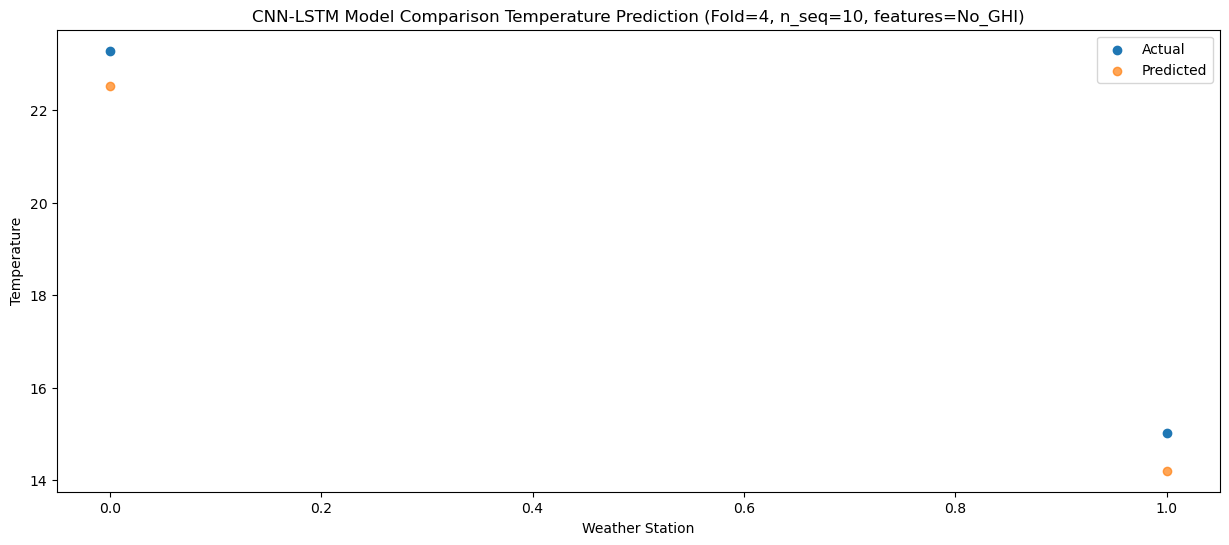

f, t:
[[21.14 12.63]
 [22.01 14.58]
 [22.53 15.6 ]
 [22.73 15.53]
 [21.89 14.23]
 [21.76 13.53]
 [22.28 14.09]
 [21.86 14.41]
 [22.36 13.54]
 [23.29 15.02]]
[[20.70244445 12.52385821]
 [21.8108827  13.60167911]
 [22.62456919 14.38036957]
 [22.25350191 13.98765593]
 [21.73107345 13.4634655 ]
 [21.6277359  13.31887124]
 [22.30926876 14.02657387]
 [22.31171028 14.03735612]
 [21.63965783 13.33363018]
 [22.52168939 14.20558254]]
Year at t+1:
t+1 SKRMSE: 0.318372
t+1 KRMSE: 0.318372
t+1 MAE: 0.271849
t+1 SKMAPE: 0.014551
t+1 R2_SCORE: 0.994402
t+1 KMAPE: 0.014551
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.705960
t+2 KRMSE: 0.705960
t+2 MAE: 0.588719
t+2 SKMAPE: 0.038073
t+2 R2_SCORE: 0.963889
t+2 KMAPE: 0.038073
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.864998
t+3 KRMSE: 0.864998
t+3 MAE: 0.657100
t+3 SKMAPE: 0.041189
t+3 R2_SCORE: 0.937681
t+3 KMAPE: 0.041189
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.141463
t+4 KRMSE: 1.141463
t+4 MAE: 1.009421
t+4 SKMAPE: 0.060139
t+4 R

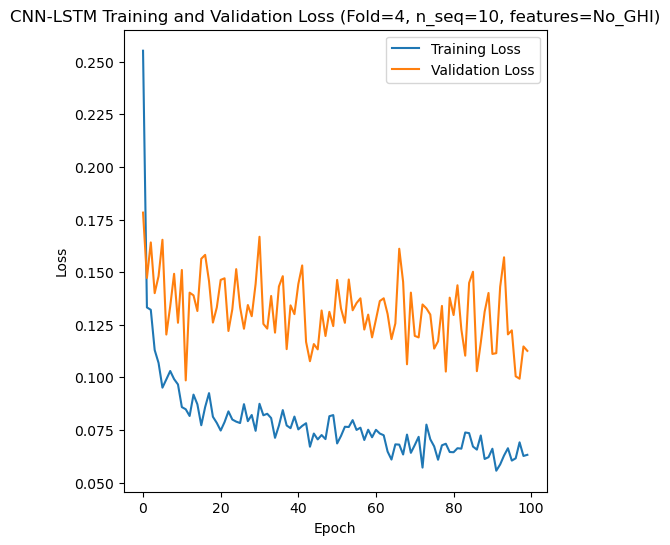

[[1.5125447986717682], [0.8481558585888164], [0.529299169617335], [1.0174083958712712], [0.6379476160893275]]
[[array(1.5125448)], [array(0.84815586)], [array(0.52929917)], [array(1.0174084)], [array(0.63794762)]]
[[1.3847996318060887], [0.689653366699815], [0.4635366022940727], [0.901247651264071], [0.48747601594962175]]
[[0.07104944051817216], [0.033788821910757494], [0.02917733424333164], [0.05987003203452829], [0.028886138800165977]]
[[0.45692272479902274], [-2.1963971654100822], [0.9255893629922383], [-1.6547337436948806], [0.9746112215824677]]
[[array(0.07104944)], [array(0.03378882)], [array(0.02917733)], [array(0.05987003)], [array(0.02888614)]]
[[array(0.92371541)], [array(0.03569465)], [array(0.95300653)], [array(0.24153771)], [array(0.98831816)]]
[20.39 21.69 22.42 22.78 21.56 21.49 21.66 21.49 21.73 22.15 16.37 17.64
 17.8  18.04 18.   18.95 18.12 17.61 17.89 17.72 19.63 20.16 20.45 20.41
 20.24 20.32 20.41 19.49 19.83 20.67 19.88 19.4  20.43 20.81 19.96 20.09
 20.61 20.22 

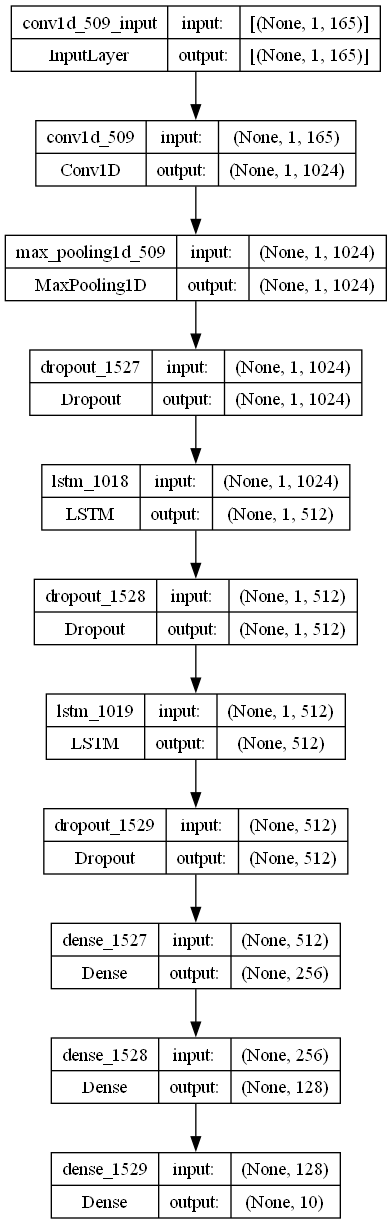

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 1024
    lr = 0.00132494657714542
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.102977358317896

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S10_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)